# Behavioral and Genetic Factors Predictive of Diabetes

# Overview

# Business Problem

# Data Understanding

Due to the size of the dataset, I can not directly push it to my online repository. The **dataset can be accessed here**:

- [2022 BRFSS Survey Data and Documentation](https://www.cdc.gov/brfss/annual_data/annual_2022.html)

The **codebook** can be accessed here:

- [LLCP 2022: Codebook Report](/Users/emmascotson/Documents/capstone_flatiron/data/Codebook_Report.pdf)

# Data Preparation

This dataset has so many columns. It will be most efficient to **harness domain knowledge** for initial feature selection, rather than going through the entirety of the codebook. Then I can hone and tweak as needed.

Below are some *Risk Factors of Diabetes* that exist as features in this dataset, pulled from various credible sources such as the American Heart Association, National Institutes of Health, Maya Clinic, Centers for Disease Control and Prevention, etc.

## Diabetes Risk Factors

#### High Risk

High risk factors directly linked to the development of Type 2 Diabetes:

- **Weight**: Being overweight or obese
- **Exercise/Activity**: Being less physically active active (less than 3 times a week)
- **Family History**: Having a parent or sibling with diabetes
- **Race and Ethnicity**: People of certain races and ethnicites - *including Black, Hispanic, Native American and Asian people, and Pacific Islanders* - are more likely to develop diabetes than white people.
- **Age**: Risk increases with age, especially after ages 35-45
- **Prediabetes**: Diagnosed with prediabetes
- **Pregnancy**: Having gestational diabetes during pregnancy puts people at greater risk from developing type 2 diabetes
- **NAFLD**: Diagnosed with Non-Alcoholic Fatty Liver Disease
- **High Blood Pressure/Hypertension**
- **Smoking**

#### Other Possible Risk Factors

Additional risk factors that might help indirectly induce diabetes, when paired with some of the high-risk factors above.

- **Stress**: Stress hormones might cause blood sugar levels to rise, and stop insulin-producing cells in the pancreas from working properly
- **Lack of Sleep**: Insufficient sleep can cause stress hormones which disrupt the body's ability to release insulin after you eat
- **Food Quality**: Frequently eating highly processed, high-carbohydrate foods and saturated fats
- **Excess Alcohol**: Excessive alcohol consumption
- **Lower Income**
- **Gum Disease**: Inflammation from gum disease can lead to higher blood glucose levels
- **Pancreatic Cancer**: Diabetes might be a symptom of pancreatic cancer

#### Additional Considerations

Depending on the amount of time remaining prior to our deadline, and -- Asthma, other kinds of cancer, arthritis

Type 1 VS. Type 2 -- **In the United States**, white people more likely to develop type 1 usually in children, teens, or young adults

# Modeling

# Evaluation

In [6]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.python.client import device_lib

from google.colab import drive
from google.colab import files

import os
import zipfile
import shutil

In [2]:
print(os.getcwd())
# List files in the current directory
print(os.listdir('.'))

/content
['.config', 'sample_data']


# Loading the Data - Colab Pro

**(Originally worked in notebook on local repo, switched to Colab Pro -- leaving code to load files in local repo as markdown)**:

##### Specify the full path to the XPT file
file_path = '/Users/emmascotson/Documents/capstone_flatiron/data/diabetes.xpt'

##### Attempt to read the XPT file
try:
    data = pd.read_sas(file_path, format='xport')
    print(data.head())
except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
uploaded = files.upload()

Saving capstone_flatiron.zip to capstone_flatiron.zip


In [8]:
# Define the path to the ZIP file and the extraction directory
zip_path = '/content/capstone_flatiron.zip'
extract_path = '/content'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [9]:
# List the contents of the /content directory
!ls /content

capstone_flatiron  capstone_flatiron.zip  drive  sample_data


In [10]:
# Define the destination directory path in Google Drive
drive_data_directory = '/content/drive/MyDrive/Colab Notebooks/data'

# Create the directory if it does not exist
os.makedirs(drive_data_directory, exist_ok=True)

In [11]:
# Define source and destination paths
source_data_path = '/content/capstone_flatiron/data/diabetes.xpt'  # Adjust path
destination_data_path = '/content/drive/MyDrive/Colab Notebooks/data/diabetes.xpt'  # Adjust path

# Move the file
shutil.move(source_data_path, destination_data_path)

'/content/drive/MyDrive/Colab Notebooks/data/diabetes.xpt'

In [12]:
# Define the path to the XPT file
xpt_file_path = '/content/drive/MyDrive/Colab Notebooks/data/diabetes.xpt'  # Adjust path

# Load the XPT file
data = pd.read_sas(xpt_file_path, format='xport')

In [13]:
# List available devices
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10256194560885193439
xla_global_id: -1
]


In [14]:
data.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_SMOKGRP,_LCSREC,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4
0,1.0,1.0,b'02032022',b'02',b'03',b'2022',1100.0,b'2022000001',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,1.0,2.0,2.0
1,1.0,1.0,b'02042022',b'02',b'04',b'2022',1100.0,b'2022000002',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,2.0,2.0,2.0
2,1.0,1.0,b'02022022',b'02',b'02',b'2022',1100.0,b'2022000003',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,2.0
3,1.0,1.0,b'02032022',b'02',b'03',b'2022',1100.0,b'2022000004',2.022000e+09,1.0,...,3.0,2.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0,9.0,9.0,2.0
4,1.0,1.0,b'02022022',b'02',b'02',b'2022',1100.0,b'2022000005',2.022000e+09,1.0,...,4.0,NaN,1.0,1.000000e+01,1.0,1.400000e+02,1.0,NaN,NaN,2.0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Columns: 328 entries, _STATE to _AIDTST4
dtypes: float64(323), object(5)
memory usage: 1.1+ GB


# Preprocessing

### Codebook Dictionary: 'codebook_key'

There are so many columns in the dataset, I'll need to filter through the Codebook PDF provided by the CDC, and extract relevant features related to the Diabetes Risk Factors outlined at the start of this notebook.

Breaking down the

To minimize the amount of time I have to refer back to the Codebook...I'll make a **dictionary called 'codebook_key'** which contains column names and the meanings of their answer values as key-value pairs.

I will do this as I go, then print 'codebook_key' whenever I need to refer back.

*NOTE: The goal & focus with regards to feature selection has changed drastically as this project has progressed. Some features were added to 'codebook key' in previous iterations of this notebook, that might no longer exist at all in any of the models below. I'm going to leave them in the codebook_key dictionary, in case they happen to become relevant down the line.

## Filtering for Risk Factors

### Genetic Factors

In my first iteration of this notebook - a FSM ('First Simple Model') - I tried filtering for only genetic/"involuntary" risk factors that could be predictive of diabetes.

However lifestyle/behavioral/voluntary choices a person makes are essential to gaining a comprehensive, clear picture of a person's risk of developing diabetes. Especially when paired with knowledge of their genetic predispositions to the disease.

I'll keeping some of the code initially used to filter genetic factors below, to display the logic for certain feature selections. I will then combine this with new code, which uses new and additional **domain knowledge**, to add behavioral factors and remove irrelevant genetic ones.

In [13]:
columns_to_keep = ['CADULT1', 'CELLSEX1', 'CSTATE1', 'SEXVAR', 'GENHLTH', 'PHYSHLTH', 'PRIMINSR',
                   'PERSDOC3', 'MEDCOST1', 'RMVTETH4', 'PREGNANT', 'WEIGHT2', 'HEIGHT3', 'SMOKE100', 'SMOKDAY2',
                   '_STATE', 'PDIABTS1', 'PREDIAB2', 'DIABETE4', 'DIABTYPE', 'INSULIN1',
                   'CHKHEMO3', 'EYEEXAM1', 'DIABEYE1', 'FEETSORE', 'CNCRTYP2',
                   'CAREGIV1', 'CRGVREL4', 'CRGVPRB3',
                   'CRGVALZD', 'LSATISFY', 'BIRTHSEX', 'RRCLASS3',
                   'RRPHYSM2', '_METSTAT', '_URBSTAT', 'MSCODE', '_IMPRACE', '_CHISPNC', '_RFHLTH',
                   '_PHYS14D', '_HLTHPLN', '_MICHD',
                   '_MRACE2', '_HISPANC', '_RACE1', '_RACEG22', '_RACEGR4', '_SEX', '_AGEG5YR',
                   '_AGE65YR', '_AGE80', '_AGE_G', 'HTIN4', 'WTKG3', '_BMI5', '_BMI5CAT', '_RFBMI5',
                   '_INCOMG1', '_SMOKER3', '_YRSSMOK', '_SMOKGRP', '_RFBING6', '_RFDRHV8']

In [14]:
# Creating new filtered dataframe for First Simple Model

df = data[columns_to_keep]

In [18]:
df.head()

,CADULT1,CELLSEX1,CSTATE1,SEXVAR,GENHLTH,PHYSHLTH,PRIMINSR,PERSDOC3,MEDCOST1,RMVTETH4,...,WTKG3,_BMI5,_BMI5CAT,_RFBMI5,_INCOMG1,_SMOKER3,_YRSSMOK,_SMOKGRP,_RFBING6,_RFDRHV8
0,NaN,NaN,NaN,2.0,2.0,88.0,99.0,1.0,2.0,NaN,...,NaN,NaN,NaN,9.0,9.0,4.0,NaN,4.0,1.0,1.0
1,NaN,NaN,NaN,2.0,1.0,88.0,3.0,2.0,2.0,NaN,...,6804.0,2657.0,3.0,2.0,3.0,4.0,NaN,4.0,1.0,1.0
2,NaN,NaN,NaN,2.0,2.0,2.0,1.0,1.0,2.0,NaN,...,6350.0,2561.0,3.0,2.0,6.0,4.0,NaN,4.0,1.0,1.0
3,NaN,NaN,NaN,2.0,1.0,88.0,99.0,1.0,2.0,NaN,...,6350.0,2330.0,2.0,1.0,9.0,2.0,56.0,3.0,1.0,1.0
4,NaN,NaN,NaN,2.0,4.0,2.0,7.0,2.0,2.0,NaN,...,5398.0,2177.0,2.0,1.0,3.0,4.0,NaN,4.0,1.0,1.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 65 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   CADULT1   349080 non-null  float64
 1   CELLSEX1  349079 non-null  float64
 2   CSTATE1   349072 non-null  float64
 3   SEXVAR    445132 non-null  float64
 4   GENHLTH   445129 non-null  float64
 5   PHYSHLTH  445127 non-null  float64
 6   PRIMINSR  445128 non-null  float64
 7   PERSDOC3  445130 non-null  float64
 8   MEDCOST1  445128 non-null  float64
 9   RMVTETH4  443769 non-null  float64
 10  PREGNANT  79018 non-null   float64
 11  WEIGHT2   429231 non-null  float64
 12  HEIGHT3   428077 non-null  float64
 13  SMOKE100  413355 non-null  float64
 14  SMOKDAY2  164053 non-null  float64
 15  _STATE    445132 non-null  float64
 16  PDIABTS1  140248 non-null  float64
 17  PREDIAB2  140222 non-null  float64
 18  DIABETE4  445129 non-null  float64
 19  DIABTYPE  12600 non-null   float64
 20  INSU

## Lowercase Column Names

Let's **lowercase all the column names**, to increase readability.

## Convert Datatypes: Float to Integer

Right now, all of our values are floats. However, looking at the data...it seems like they all can easily be converted to integers (all numbers appear to end with '.0', and there are no need for decimals).

Making everything 'int' dtype will make things simpler and improve readbility.

I'll have to deal with Null Values before I can do this.

#### Other Cleaning

There's such a large number of columnns, even in this smaller FSM -- I want to optomize time by moving on to explore the data and continuing to "clean as I go" if I run into any other issues. Rather than assessing any need to clean answer values for each column right now as well.

Furthermore, from what I've seen in the Codebook, this dataset is extremely well-organized compared to some past datasets I've worked with. I therefore feel confident in assuming that most of the answer-values in the rows themselves are pretty clean, and I can optomize time by moving forward and dealing with any other issues as they arise.

In [15]:
# lowercasing column names
df.columns = df.columns.str.lower()

## Nulls

It seems like there are some columns with completely missing values. Let's re-print the columns in ascending order of non-null values to reference back to the Codebook and examine whether our Null values are accurate.

In [21]:
# Get non-null counts for each column
non_null_counts = df.notnull().sum()

# Sort columns by non-null counts in ascending order
sorted_columns = non_null_counts.sort_values().index

# Reorder DataFrame columns based on sorted order
df_sorted = df[sorted_columns]

# Print info of the sorted DataFrame
print(df_sorted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 65 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   diabeye1  12600 non-null   float64
 1   chkhemo3  12600 non-null   float64
 2   insulin1  12600 non-null   float64
 3   diabtype  12600 non-null   float64
 4   feetsore  12600 non-null   float64
 5   eyeexam1  12600 non-null   float64
 6   crgvalzd  17300 non-null   float64
 7   crgvprb3  19472 non-null   float64
 8   crgvrel4  19634 non-null   float64
 9   cncrtyp2  22544 non-null   float64
 10  pregnant  79018 non-null   float64
 11  birthsex  79427 non-null   float64
 12  mscode    93886 non-null   float64
 13  caregiv1  98510 non-null   float64
 14  prediab2  140222 non-null  float64
 15  pdiabts1  140248 non-null  float64
 16  _yrssmok  147604 non-null  float64
 17  rrphysm2  160190 non-null  float64
 18  rrclass3  161738 non-null  float64
 19  smokday2  164053 non-null  float64
 20  lsat

# CHANGE EMMA!!!!! : EXAMPLE CODE BELOW

##### HAVECFS and TOLDCFS

The codebook confirms that the data is completely missing for all rows in these columns, which indicate a person's status with regards to having or being told they have **Chronic Fatigue Syndrome (CFS)** or **Myalgic Encephalomyelitis**.

##### PSATEST1

Survey Question: *Have you ever had a P.S.A. test?*

*PSA test*: measures the amount of PSA in a man's blood to help screen for and monitor prostate cancer.

According to Cleveland Clinic PSA tests are very common. Which leaves us to wonder why so many of these values are Nulls -- certainly a far greater number than the amount of men that were surveyed in the dataset.


##### COPDCOGH AND COPDFLEM

Survey Question: *During the past three months, did you have a cough and/or cough up phlegm or mucus on most days?

These columns might be more of the **hindsight bias** symptoms I was referring to early, rather than prior warning signs. It's not a big deal if we have a lot of Nulls for these, we have other genetic and physical factors that will be far more important to our model.

##### CDDISCUS

Survey Question: Have you are anyone else discussed your confusion or memory loss with a health care professional?

Again, not one of our most important features, so no need to stress that there are a lot of Nulls.

An interesting takeaway from the Codebook Report with regards to this feature: the **non**-missing values seemed to be pretty balanced between our two main class...3,432 'Yes' and 3,862 'No'.

##### CSVRTRN, CSRVSUM

Survey Question CSVRTRN: Have you ever received instructions from a doctor, nurse, or other health professional about where you should return or who you should see for routine cancer check-
ups after completing treatment for cancer?

Survey Question CSRVSUM: Did any doctor, nurse, or other health professional ever give you a written summary of all the cancer treatments that you received?

These are sort of behavioral questions, as they bleed into the question of whether or not people choose to incorporate doctor's visits into their lifestyle routines. I thought they might be helpful in isolating whether people had **reasons** to go to the doctor (due to underlying genetic conditions), but there are other features we have that are more suitable for this anyway.

##### CSRVDOC1

Survey Question: What type of doctor provides the majority of your health care? Is it a….

This could still be useful, even if we have Nulls, to identify any specialized possibly genetic reasons a person requires specific medical care from a particular kind of doctor. But again, not entirely important compared to other features. So it's okay that we have mostly Nulls.

### Moving On

The rest of our columns have over 10,000 non-null values. To save time, I'll keep moving for now and examine these as I go if need be.

# Target Variable

The risk factors of diabetes Type 1 and Type 2 are different. However according to the Codebook there's a discrepancy in the results of columns 'diabete4' and 'diabtype': 'diabete4' has over 60,000 records of respondents that **are** diagnosed with *any* form of diabetes...yet 'diabtype' has only about 11,000 records of respondents diagnosed with diabetes, categorizing them as Type 1 or Type 2.

Ideally, I'll build a model that takes into account the differences in diabetes risk factors by varying type. However to start, I'll pick the feature with less "missingness", 'diabete4', then hopefully pair domain knowledge with the information provided in 'diabtype' to further categorize people diabetes into 'Type 1' and 'Type 2'.

## Target: diabete4

**Target Survey Question**: (Ever told) (you had) diabetes? (If ´Yes´ and respondent is female, ask ´Was this only when you were pregnant?´. If Respondent says pre-diabetes or borderline diabetes, use response code 4.)

**Target Answer Values**...

In [16]:
# ADDING TO CODEBOOK DICTIONARY
codebook_key = {
    'diabete4': {
        'Question': "(Ever told) (you had) diabetes? (If 'Yes' and respondent is female, ask 'Was this only when you were pregnant?´.",
        'Answers': {
        1: 'Yes',
        2: 'Yes, but female told only during pregnancy',
        3: 'No',
        4: 'No, pre-diabetes or boderline diabetes',
        7: 'Dont know/Not sure',
        9: 'Refused',
        'BLANK': 'Not asked or Missing'
        }
    }
}

**Nulls**

445129 non-null values, 3 missing values

Our target class barely has any missingness. And looking at the *frequency values* in the Codebook, there are only 1084 of the 'Don't know/Not Sure' and 'Refused' values combined. Obviously the greater the volume of rows and data with regards to the target variable, the better.

I'll print the frequencies of the other values shortly.

### Columns to Contextualize Target: pdiabts1, prediab2, diabtype, pregnant

##### pdiabts1

Survey Question: When was the last time you had a blood test for high blood sugar or diabetes by a doctor, nurse, or other health professional?

140,248 non-null, 304,884 missing malues

##### prediab2

Survey Question: Has a doctor or other health professional ever told you that you had prediabetes or borderline diabetes? (If “Yes” and respondent is female, ask: “Was this only when you were pregnan

140,222 non-null, 304,910 missing values

#### diabtype

Survey Question: According to your doctor or other health professional, what type of diabetes do you have?

Answer Values: *Type 1, Type 2, Don't know/Not Sure, Refused, Not asked or Missing*

This column could be a good way to expand the target variable with more specifity, as I move onto to larger more complex models after this FSM. If I have time, I can start to develop a chained model that not only predicts whether someone develops diabetes, but further predicts which type they will progress to. Otherwise, I can use it to contextualize my findings.

12,600 non-null, 432,532 missing values

In [ ]:
df['diabete4'].value_counts(normalize=True)

,proportion
diabete4,
3.0,0.828349
1.0,0.137394
4.0,0.023205
2.0,0.008618
7.0,0.001714
9.0,0.000721


#### Imbalanced Target

82.83% of the target variable is 'No', and only 13.74% of the target variable is 'Yes'.

I'll have to keep this in mind when building the model!

## Feature Selection & Importance

### Genetic Factors: Linear Relationship?

With concrete genetic factors, there might be a stronger **linear relationship** between these features and whether a person has diabetes, compared with the behavioral/lifestyle choices a person can make that can create messier/more complex non-linear relationships in the data.

Let's print the **correlation coefficients** between each of our features and our target variable to look for signs of predictive importance, as well as a **correlation matrix** to look for signs of multicollinearity between features.

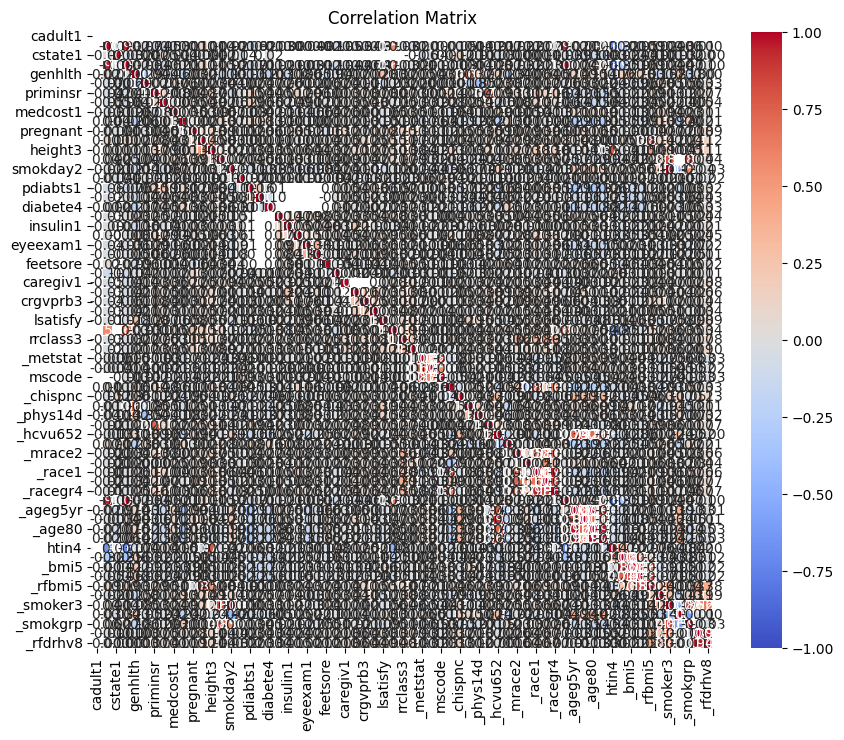

In [23]:
# printing correlation matrix

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Woah!! This is totally uninterpretable.

Let's try two things:

1) Printing the **pairs of features with the highest correlation** values
2) Using **clustering** to identify **groups of similar features**, and printing smaller corrrelation matrices based on these groups.

#### Printing Pairs of Correlated Features

In [ ]:
correlation_matrix = df.corr().abs()  # Take the absolute value to focus on the strength of correlations
np.fill_diagonal(correlation_matrix.values, 0)  # Set diagonal to 0 to ignore self-correlations

# Find the indices of the maximum correlations
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Display the top pairs
print(high_corr_pairs.head(10))

Woah! A ton of HIGHLY correlated pairs. Let's print a greater number so we can examine further.

In [ ]:
# Assuming 'df' is your DataFrame
correlation_matrix = df.corr().abs()  # Take the absolute value to focus on the strength of correlations
np.fill_diagonal(correlation_matrix.values, 0)  # Set diagonal to 0 to ignore self-correlations

# Find the indices of the maximum correlations
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Display the top pairs
print(high_corr_pairs.head(50))

Wow. Even printing the top 50, as opposed to the top 10, all the features are highly correlated.

We can't move on to **K-Means Clustering** to group features, with so many (or really any) NaNs still in the dataframe. Let's harness domain knowledge from the Codebook to cut down correlated features, then printed correlated pairs again, then move on to clustering if possible.

### Correlated Pairs: Using Codebook

It's clear there are highly interrelated groups of features based on the correlated pairs printed above. Rather than wasting time identifying each of these features and their meaning in a markdown, I'll identify the group "category" (such as 'Smoking Habits'), and refer to the Codebook to identify which select feature(s) from this group will be most useful and why.

I'll want to print the **number of non-nulls** in addition to the column names, so I can try and try and pick features with less NaN's if possible during my selection. This will help make imputations and cleaning easier to prepare for clustering.

#### Smoking Habits

In [ ]:
# Find columns with 'smok' in their names
smok_columns = [col for col in df.columns if 'smok' in col.lower()]

# Print column names and their number of non-null values
for col in smok_columns:
    non_null_count = df[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: smoke100, Non-null count: 413355
Column: smokday2, Non-null count: 164053
Column: _smoker3, Non-null count: 445132
Column: _yrssmok, Non-null count: 147604
Column: _smokgrp, Non-null count: 409670


##### SELECTS TO KEEP: _smokgrp

Survey Question: Smoking Group

Answer Values...

In [17]:
#ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_smokgrp'] = {
    'Question': 'Smoking Group',
    'Answers': {
    1: 'Current smoker, 20+ Pack Years',
    2: 'Former smoker, 20+ Pack years, quit < 15 years',
    3: 'All other current and former smokers',
    4: 'Never smoker',
    0: 'Dont know/Refused/Missing'
    }
}

In [18]:
# List of columns to drop
columns_to_drop = ['smoke100', 'smokday2', '_smoker3', '_yrssmok']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# Use .loc to fill NaN values in '_smokgrp' with 0
df.loc[:, '_smokgrp'] = df['_smokgrp'].fillna(0)

#### Sex Group

In [19]:
# Find columns with 'sex' in their names
sex_columns = [col for col in df.columns if 'sex' in col.lower()]

# Print column names and their number of non-null values
for col in sex_columns:
    non_null_count = df[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: cellsex1, Non-null count: 349079
Column: sexvar, Non-null count: 445132
Column: birthsex, Non-null count: 79427
Column: _sex, Non-null count: 445132


##### SELECTS TO KEEP: _sex

Survey Question: Calculated sex variable

Answer Values...

In [20]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_sex']: {
    'Question': 'Calculated sex variable',
    'Answers': {
    1: 'Male',
    2: 'Female',
    }
}

In [21]:
# List of columns to drop
columns_to_drop = ['cellsex1', 'sexvar', 'birthsex']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

#### Age Group

In [22]:
# Find columns with 'age' in their names
age_columns = [col for col in df.columns if 'age' in col.lower()]

# Print column names and their number of non-null values
for col in age_columns:
    non_null_count = df[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: _ageg5yr, Non-null count: 445132
Column: _age65yr, Non-null count: 445132
Column: _age80, Non-null count: 445132
Column: _age_g, Non-null count: 445132


##### SELECTS TO KEEP: _age_g


##### _age_g

Survey Question: Six-level imputed age category

Answer Values...

In [23]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_age_g'] = {
    'Question': 'Six-level imputed age category',
    'Answers': {
    1: 'Age 18 to 24',
    2: 'Age 25 to 34',
    3: 'Age 35 to 44',
    4: 'Age 45 to 54',
    5: 'Age 55 to 64',
    6: 'Age 65 or older'
    }
}

# Irrelevant feature in previous iteration of notebook
codebook_key['cncrage'] = {
    'Question': 'At what age were you told that you had cancer? (If Response = 2 (Two) or 3 (Three or more), ask: “At what age was your first diagnosis of cancer?”)',
    'Answers': {
    '1-97': 'Age in years (97=97 and older)',
    98: 'Dont know/Not Sure',
    99: 'Refused',
    0: 'Missing'
    }
}

Adding 'cadult1' to columns to drop by using domain knowledge and referencing codebook.

In [24]:
# List of columns to drop
columns_to_drop = ['_ageg5yr', '_age65yr', '_age80', 'cadult1']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

#### Race

In [25]:
# Find columns with 'race' in their names
race_columns = [col for col in df.columns if 'race' in col.lower()]

# Print column names and their number of non-null values
for col in race_columns:
    non_null_count = df[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: _imprace, Non-null count: 445132
Column: _mrace2, Non-null count: 445121
Column: _race1, Non-null count: 445130
Column: _raceg22, Non-null count: 445130
Column: _racegr4, Non-null count: 445130


##### SELECTS TO KEEP: _raceg22

Survey Question: White non-Hispanic race group

Answer Values...

In [26]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_raceg22'] = {
    'Question': 'White non-Hispanic race group',
    'Answers': {
    1: 'Non-Hispanic White',
    2: 'Non-White or Hispanic',
    9: 'Dont know/Not sure/Refused',
    0: 'Missing'
    }
}

##### FURTHER ANALYSIS: _race1

At the start of my analysis and modeling, I need to narrow focus. Domain knowledge tells me that, for unknown reasons, white people are less likely to develop diabetes. I can start with this generalized distinction using '_raceg22' as my main feature related to race. I'd like to include more specific and nuanced analysis in my results if possible...if I have time, I can use '_race1' to examine a more nuanced and detailed breakdown of race as it related to diabetes.

##### _race1

Survey Question: Race/ethnicity categories

Answer Values...

In [27]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_race1'] = {
    'Question': 'Race/ethnicity categories',
    'Answers': {
    1: 'White only, non-Hispanic',
    2: 'Black only, non-Hipsnaic',
    3: 'American Indian or Alaskan Native only, Non-Hispanic',
    4: 'Asian only, non-Hispanic',
    5: 'Native Hawaiin or other Pacific Islander only, Non-Hispanic',
    7: 'Multiracial, non-Hispanic',
    8: 'Hispanic',
    9: 'Dont know/Not Sure/Refuse',
    0: 'Missing'
    }
}

Adding '_hispanc' to columns to drop using Codebook and domain knowledge.

In [28]:
# List of columns to drop
columns_to_drop = ['_imprace', '_mrace2', '_racegr4', '_race1', '_hispanc']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

#### Height

In [29]:
# Find columns with 'height' or 'ht' in their names
height_columns = [col for col in df.columns if 'height' in col.lower() or 'ht' in col.lower()]

# Print column names and their number of non-null values
for col in height_columns:
    non_null_count = df[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: weight2, Non-null count: 429231
Column: height3, Non-null count: 428077
Column: htin4, Non-null count: 412656


#### Dropping Height

From domain knowledge I know that height can be used to help predict diabetes when used to calculate the proportion of a person's height to the circumference of their waist. This dataaset does not include information on waist circumference, but it does provide information on a person's **BMI**, which is another weight-to-height based metric that is predictive of diabetes. I'll drop all other height columns, since it's used and most useful when calculating 'BMI' anyway.

In [30]:
# Irrelevant feature included in previous iteration of notebook
codebook_key['height3'] = {
    'Question': 'About how tall are you without shoes? (If respondent answers in metrics, put a 9 in the first column)',
    'Answers': {
    '200-711': 'Height (ft/inches)',
    0: 'Missing',
    'NOTES': '0_/_ _=feet/inches'
    }
}

In [31]:
# List of columns to drop
columns_to_drop = ['htin4', 'height3']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

Adding 'chcscnc1' to columns to drop using domain knowledge and referencing codebook.

#### Correlated Pairs

Let's print our Correlated Pairs again, now that we've narrowed focus.

In [32]:
# Assuming 'fsm' is your DataFrame
correlation_matrix = df.corr().abs()  # Take the absolute value to focus on the strength of correlations
np.fill_diagonal(correlation_matrix.values, 0)  # Set diagonal to 0 to ignore self-correlations

# Find the indices of the maximum correlations
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Display the top pairs
print(high_corr_pairs.head(50))

_rfbing6  _rfdrhv8    0.939160
_rfdrhv8  _rfbing6    0.939160
mscode    _metstat    0.865803
_metstat  mscode      0.865803
wtkg3     _bmi5       0.859557
_bmi5     wtkg3       0.859557
_bmi5cat  _rfbmi5     0.854818
_rfbmi5   _bmi5cat    0.854818
_bmi5     _bmi5cat    0.832352
_bmi5cat  _bmi5       0.832352
weight2   _rfbmi5     0.828977
_rfbmi5   weight2     0.828977
_bmi5cat  wtkg3       0.743352
wtkg3     _bmi5cat    0.743352
_hlthpln  priminsr    0.733702
priminsr  _hlthpln    0.733702
genhlth   _rfhlth     0.675082
_rfhlth   genhlth     0.675082
_bmi5     _rfbmi5     0.649035
_rfbmi5   _bmi5       0.649035
_urbstat  _metstat    0.624926
_metstat  _urbstat    0.624926
_smokgrp  _rfdrhv8    0.596060
_rfdrhv8  _smokgrp    0.596060
_rfbing6  _smokgrp    0.585503
_smokgrp  _rfbing6    0.585503
mscode    _urbstat    0.557608
_urbstat  mscode      0.557608
rrclass3  _raceg22    0.394024
_raceg22  rrclass3    0.394024
_rfdrhv8  _rfbmi5     0.382994
_rfbmi5   _rfdrhv8    0.382994
diabeye1

Still need to cut down some more by category!

#### 'rf'

Let's remind ourselves what 'rf' means.

In [ ]:
# Find columns with 'age' in their names
rf_columns = [col for col in df.columns if 'rf' in col.lower()]

# Print column names and their number of non-null values
for col in rf_columns:
    non_null_count = df[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: _rfhlth, Non-null count: 445132
Column: _rfbmi5, Non-null count: 445132
Column: _rfbing6, Non-null count: 445132
Column: _rfdrhv8, Non-null count: 445132


Hmmm...These don't actually seem to be explicitly interrelated:

**_rfhlth**: Adults with good or better health

**_rfbmi5**: Adults who have a body mass index greater than 25.00 (Overweight or Obese)

**_rfbing6**: Binge drinkers (males having five or more drinks on one occasion, females having four or more drinks on one occasion)

**_rfdrhv8**: Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week)

The last two having to do with drinking have an overlap of content. But it might be a helpful distinction. Let's leave it for now.

#### BMI

In [ ]:
# Find columns with 'age' in their names
bmi_columns = [col for col in df.columns if 'bmi' in col.lower()]

# Print column names and their number of non-null values
for col in bmi_columns:
    non_null_count = df[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: _bmi5, Non-null count: 396326
Column: _bmi5cat, Non-null count: 396326
Column: _rfbmi5, Non-null count: 445132


##### SELECTS TO KEEP: _bmi5cat

Survey Question: Four-categories of Body Mass Index (BMI)

Answer Values...

In [33]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_bmi5cat'] = {
    'Question': 'Four-categories of Body Mass Index (BMI)',
    'Answers': {
    1: 'Underweight',
    2: 'Normal Weight',
    3: 'Overweight',
    4: 'Obese',
    0: 'Dont know/Refused/Missing'
    }
}

Adding 'weight2' and 'wtkg3' to columns to drop using domain knowledge and codebook.

In [34]:
# List of columns to drop
columns_to_drop = ['_bmi5', '_rfbmi5', 'weight2', 'wtkg3']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# Use .loc to fill NaN values in 'cncrage' with 0
df.loc[:, '_bmi5cat'] = df['_bmi5cat'].fillna(0)

#### Physical/General Health

In [ ]:
# Find columns
health_columns = [col for col in df.columns if 'hlth' in col.lower() or 'phys' in col.lower()]

# Print column names and their number of non-null values
for col in health_columns:
    non_null_count = df[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: genhlth, Non-null count: 445129
Column: physhlth, Non-null count: 445127
Column: rrphysm2, Non-null count: 160190
Column: _rfhlth, Non-null count: 445132
Column: _phys14d, Non-null count: 445132
Column: _hlthpln, Non-null count: 445132


##### SELECTS TO KEEP: priminsr

The other two selects, in addition to 'priminsr', that I inititally considered keeping were:

- **'_rfhlth'**: Adults with good or better health
- **'_phys14d'**: 3 level not good physical health status: 0 days, 1-13 days, 14-30 days

However, it's not very useful to look at a person's "general health" status, while also examining more specific health factors closely related to diabetes that will provide a picture of a person's general health already.

##### priminsr

**Added to category using domain knowledge/codebook**

Survey Question: What is the current primary source of your health insurance?

Answer Values

In [35]:
codebook_key['priminsr'] = {
    'Question': 'What is the current primary source of your health insurance?',
    'Answers': {
        2: 'A private nongovernmental plan that you or another family member buys on your own',
        3: 'Medicare',
        4: 'Medigap',
        5: 'Medicaid',
        6: 'Childrens Health Insurance Program (CHIP)',
        7: 'Military related health care: TRICARE (CHAMPUS) /VA hleath care/CHAMP-VA',
        8: 'Indian Health Service',
        9: 'State sponsored health plan',
        10: 'Other government program',
        88: 'No coverage of any type',
        77: 'Dont know/Not Sure',
        99: 'Refused',
        0: 'Not asked or Missing'
    }
}

Adding 'persdoc3' to columns to drop using domain knowledge & referencing codebook.

In [36]:
# List of columns to drop
columns_to_drop = ['genhlth', 'physhlth', 'rrphysm2', '_hlthpln', 'persdoc3', '_rfhlth', '_phys14d']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

#### Correlated Pairs

In [ ]:
# Assuming 'fsm' is your DataFrame
correlation_matrix = df.corr().abs()  # Take the absolute value to focus on the strength of correlations
np.fill_diagonal(correlation_matrix.values, 0)  # Set diagonal to 0 to ignore self-correlations

# Find the indices of the maximum correlations
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Display the top pairs
print(high_corr_pairs.head(50))

_rfbing6  _rfdrhv8    0.939160
_rfdrhv8  _rfbing6    0.939160
mscode    _metstat    0.865803
_metstat  mscode      0.865803
_ltasth1  _casthm1    0.752870
_casthm1  _ltasth1    0.752870
_age_g    _hcvu652    0.684079
_hcvu652  _age_g      0.684079
_metstat  _urbstat    0.624926
_urbstat  _metstat    0.624926
_smokgrp  _rfdrhv8    0.596060
_rfdrhv8  _smokgrp    0.596060
_smokgrp  _rfbing6    0.585503
_rfbing6  _smokgrp    0.585503
_urbstat  mscode      0.557608
mscode    _urbstat    0.557608
_raceg22  _hispanc    0.509550
_hispanc  _raceg22    0.509550
_smokgrp  _lcsrec     0.438588
_lcsrec   _smokgrp    0.438588
_raceg22  rrclass3    0.394024
rrclass3  _raceg22    0.394024
_drdxar2  _age_g      0.386245
_age_g    _drdxar2    0.386245
diabeye1  eyeexam1    0.380262
eyeexam1  diabeye1    0.380262
_asthms1  _casthm1    0.362267
_casthm1  _asthms1    0.362267
_chispnc  _age_g      0.318257
_age_g    _chispnc    0.318257
          pdiabts1    0.317671
pdiabts1  _age_g      0.317671
_bmi5cat

Still a couple high numbers between certain pairs, but this looks much better! We've narrowed down quiete a bit of repetition and overlap between similarly categorized features.

## Imputing with Placeholder: 0

Let's move to K-Means Clustering, and impute all our missing values with 0 as a placeholder for now, and see how things shake out.

Looking through the rest of the Codebook, almost none of the rows have '0' as an assigned value. The only times it might cause confusion, is in a feature that asking a certain 'number of times' a behavior was committed (ex. 'How many drinks a week do you have?'), in which 0 could be an answer.

Let's print all the columns that have '0' as a unique value and see if this pertains to any of them. In which case, we'll have to find another placeholder for missingness.

In [37]:
# Find columns with '0' as a unique value in any of its rows
columns_with_zero = [col for col in df.columns if (df[col] == 0).any()]

# Print the columns
print("Columns containing '0' as a unique value:")
for col in columns_with_zero:
    print(col)

Columns containing '0' as a unique value:
_bmi5cat
_smokgrp


Fantastic!! These are all columns that I added '0' to as a placeholder to impute missingness. None of them are the few columns in the Codebook to which I was referring, which use 0 as a real answer value.

All of our columns are numeric ***float*** dtypes, so I know there's no need to check if '0' appears as a string value in any columns as well.

I can go ahead and use 0 as a placeholder for all missingness in the dataframe for this FSM. **For my larger MVP, I'll have to reasses** - when I start adding new columns into the models.

In [38]:
# Impute all NaN values with 0
df.fillna(0, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 34 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   priminsr      445132 non-null  float64
 1   medcost1      445132 non-null  float64
 2   pregnant      445132 non-null  float64
 3   _state        445132 non-null  float64
 4   prediab2      445132 non-null  float64
 5   diabete4      445132 non-null  float64
 6   chkhemo3      445132 non-null  float64
 7   eyeexam1      445132 non-null  float64
 8   lsatisfy      445132 non-null  float64
 9   asbirduc      445132 non-null  float64
 10  rrhcare4      445132 non-null  float64
 11  mscode        445132 non-null  float64
 12  _rfhlth       445132 non-null  float64
 13  _phys14d      445132 non-null  float64
 14  _hcvu652      445132 non-null  float64
 15  _michd        445132 non-null  float64
 16  _drdxar2      445132 non-null  float64
 17  _hispanc      445132 non-null  float64
 18  _rac

In [41]:
# Convert all float columns to integers
df = df.apply(lambda x: x.astype(int) if x.dtype == 'float64' else x)

## Convert dtype to int

Now that I've imputed all missingness with placeholders, I can convert my datatypes from floats to integers.

Great. Let's use clustering to print a correlation matrix by group.

## Correlated Features: K-Means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


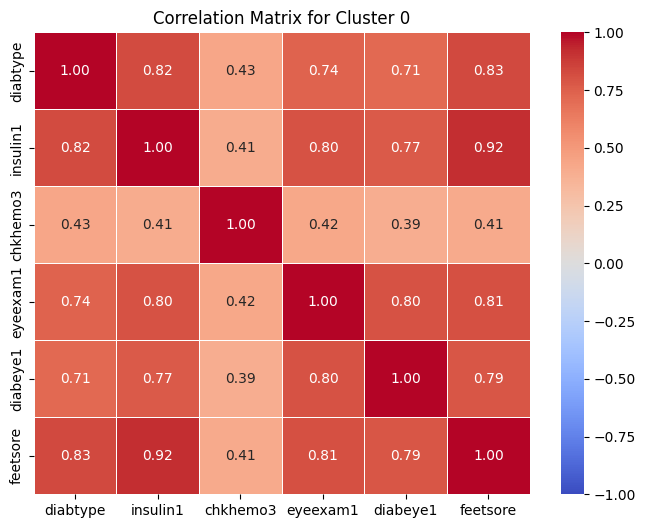

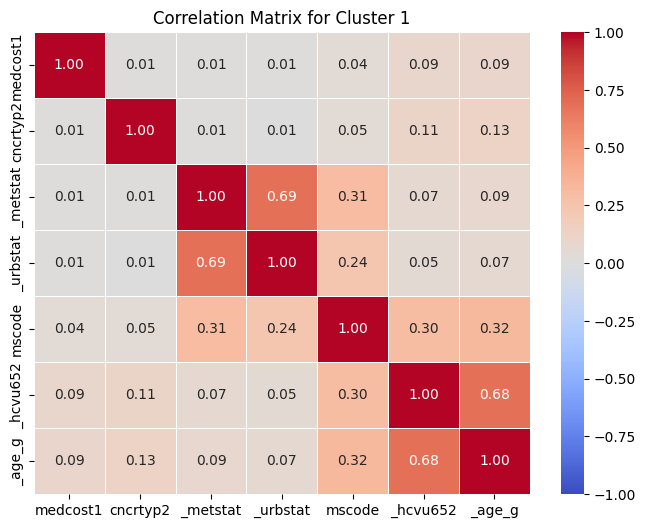

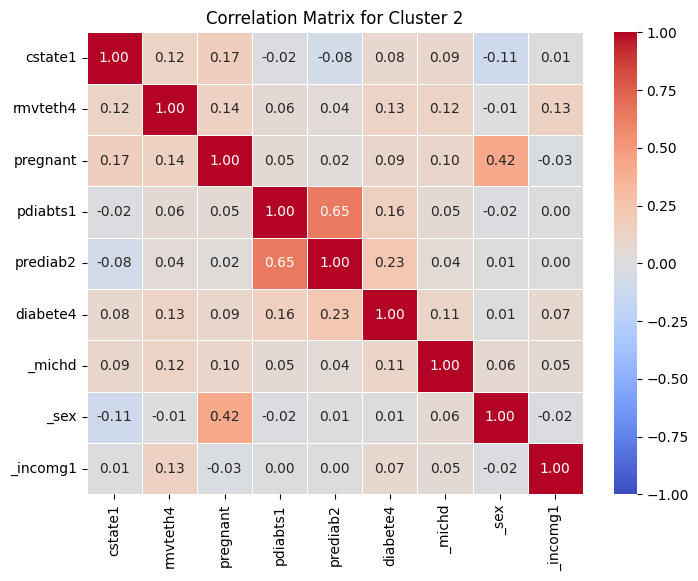

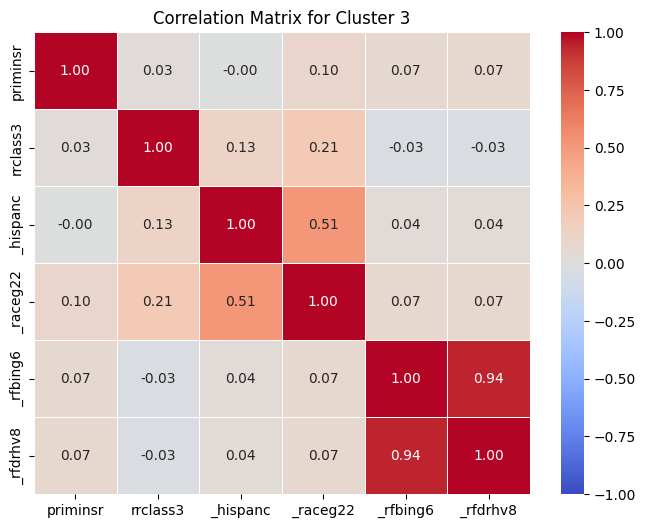

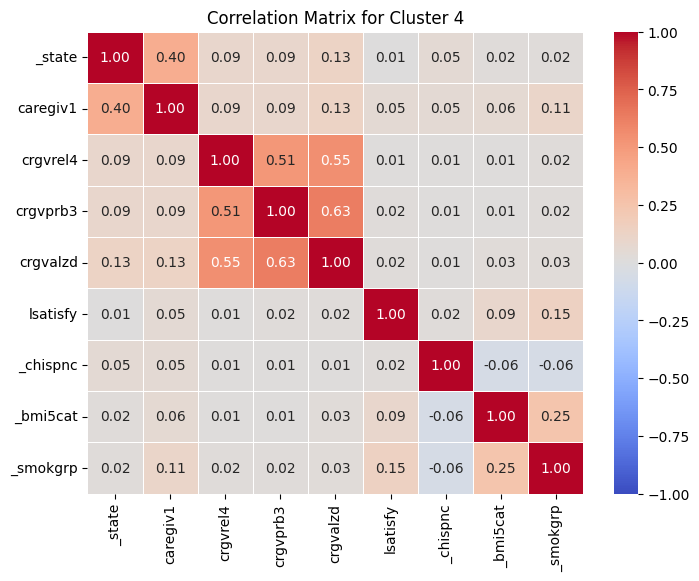

In [42]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Check for NaNs in the correlation matrix
if correlation_matrix.isnull().values.any():
    print("NaNs detected in the correlation matrix.")
    # Impute NaNs with 0 in the correlation matrix
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    correlation_matrix = pd.DataFrame(imputer.fit_transform(correlation_matrix), index=correlation_matrix.index, columns=correlation_matrix.columns)

# Flatten correlation matrix and standardize for clustering
corr_matrix_flat = correlation_matrix.values
scaler = StandardScaler()
scaled_corr_matrix = scaler.fit_transform(corr_matrix_flat)

# Perform K-Means clustering
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(scaled_corr_matrix)

# Create a DataFrame with cluster labels for each feature
feature_clusters = pd.DataFrame({
    'Feature': correlation_matrix.columns,
    'Cluster': clusters
})

# Plot correlation matrices for each cluster
for cluster in range(num_clusters):
    # Get features in the current cluster
    cluster_features = feature_clusters[feature_clusters['Cluster'] == cluster]['Feature']
    cluster_corr_matrix = correlation_matrix.loc[cluster_features, cluster_features]

    plt.figure(figsize=(8, 6))  # Set the size of the plot
    sns.heatmap(cluster_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix for Cluster {cluster}')
    plt.show()

### Feature Clusters

In [43]:
print(feature_clusters)

     Feature  Cluster
0    cstate1        2
1   priminsr        3
2   medcost1        1
3   rmvteth4        2
4   pregnant        2
5     _state        4
6   pdiabts1        2
7   prediab2        2
8   diabete4        2
9   diabtype        0
10  insulin1        0
11  chkhemo3        0
12  eyeexam1        0
13  diabeye1        0
14  feetsore        0
15  cncrtyp2        1
16  caregiv1        4
17  crgvrel4        4
18  crgvprb3        4
19  crgvalzd        4
20  lsatisfy        4
21  rrclass3        3
22  _metstat        1
23  _urbstat        1
24    mscode        1
25  _chispnc        4
26  _hcvu652        1
27    _michd        2
28  _hispanc        3
29  _raceg22        3
30      _sex        2
31    _age_g        1
32  _bmi5cat        4
33  _incomg1        2
34  _smokgrp        4
35  _rfbing6        3
36  _rfdrhv8        3


In [ ]:
feature_clusters['Cluster'].value_counts()

,count
Cluster,
2,14
1,10
3,8
0,6
4,5


In [44]:
# Sort feature_clusters by 'Feature'
sorted_feature_clusters = feature_clusters.sort_values(by=['Feature'])

# Create clusters_summary from the sorted DataFrame
clusters_summary = sorted_feature_clusters.groupby('Cluster')['Feature'].apply(list)

# Loop through each unique cluster and print sorted features
for cluster, features in clusters_summary.items():
    print(f"Cluster {cluster}:")
    for feature in features:
        print(f"  {feature}")
    print()  # Blank line for better readability

Cluster 0:
  chkhemo3
  diabeye1
  diabtype
  eyeexam1
  feetsore
  insulin1

Cluster 1:
  _age_g
  _hcvu652
  _metstat
  _urbstat
  cncrtyp2
  medcost1
  mscode

Cluster 2:
  _incomg1
  _michd
  _sex
  cstate1
  diabete4
  pdiabts1
  prediab2
  pregnant
  rmvteth4

Cluster 3:
  _hispanc
  _raceg22
  _rfbing6
  _rfdrhv8
  priminsr
  rrclass3

Cluster 4:
  _bmi5cat
  _chispnc
  _smokgrp
  _state
  caregiv1
  crgvalzd
  crgvprb3
  crgvrel4
  lsatisfy



### diabete4 Correlation

Let's check which features are highly correlated with our target variable, diabete4. We can already get a glimpse of this based on which features were included in the same cluster as the target.

In [45]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Extract correlations with 'diabete4'
diabete4_corr = correlation_matrix['diabete4'].sort_values(ascending=False)

# Print correlations with 'diabete4'
print("Correlations with 'diabete4':")
print(diabete4_corr.head(30))
print(diabete4_corr.tail(30))

# Filter out the target variable itself (if you don't want to include it)
high_corr_features = diabete4_corr[diabete4_corr.index != 'diabete4']

# Display highly correlated features (e.g., correlation > 0.5 or < -0.5)
high_corr_features = high_corr_features[(high_corr_features > 0.5) | (high_corr_features < -0.5)]
print("\nHighly correlated features with 'diabete4':")
print(high_corr_features)

Correlations with 'diabete4':
diabete4    1.000000
prediab2    0.227082
pdiabts1    0.157076
rmvteth4    0.126222
_michd      0.110260
pregnant    0.092717
cstate1     0.078653
_incomg1    0.072352
priminsr    0.038291
_rfbing6    0.032106
_hispanc    0.026075
_rfdrhv8    0.025682
_smokgrp    0.018150
medcost1    0.018050
_raceg22    0.012576
rrclass3    0.010136
_sex        0.005764
crgvprb3   -0.003862
crgvalzd   -0.004617
crgvrel4   -0.005537
caregiv1   -0.005647
_state     -0.006623
_urbstat   -0.009253
lsatisfy   -0.013308
_metstat   -0.015660
_chispnc   -0.019846
cncrtyp2   -0.021573
mscode     -0.060082
_bmi5cat   -0.109473
_hcvu652   -0.123555
Name: diabete4, dtype: float64
_incomg1    0.072352
priminsr    0.038291
_rfbing6    0.032106
_hispanc    0.026075
_rfdrhv8    0.025682
_smokgrp    0.018150
medcost1    0.018050
_raceg22    0.012576
rrclass3    0.010136
_sex        0.005764
crgvprb3   -0.003862
crgvalzd   -0.004617
crgvrel4   -0.005537
caregiv1   -0.005647
_state     -0.0

##### Change Threshold

Right now, there don't seem to be any features highly correlated with our target. This could change as we continue to drop more from the dataframe. For now, let's set a smaller threshold from 0.5 and -0.5

In [46]:
# Filter out the target variable itself (if you don't want to include it)
high_corr_features = diabete4_corr[diabete4_corr.index != 'diabete4']

# Display highly correlated features (e.g., correlation > 0.5 or < -0.5)
high_corr_features = high_corr_features[(high_corr_features > 0.1) | (high_corr_features < -0.1)]
print("\nHighly correlated features with 'diabete4':")
print(high_corr_features)


Highly correlated features with 'diabete4':
prediab2    0.227082
pdiabts1    0.157076
rmvteth4    0.126222
_michd      0.110260
_bmi5cat   -0.109473
_hcvu652   -0.123555
chkhemo3   -0.163754
_age_g     -0.183294
diabeye1   -0.320260
eyeexam1   -0.329582
diabtype   -0.335620
insulin1   -0.371270
feetsore   -0.384525
Name: diabete4, dtype: float64


Breakdown of these features below...by adding their question and answer values to the dictionary codebook key.

In [47]:
# ADDING ONLY FEATURES NOT ALREADY IN DICT

# List of highly correlated feature names in their original order
highly_correlated_features = [
    'prediab2',
    'pdiabts1',
    'rmvteth4',
    '_drdxar2',
    '_michd',
    '_bmi5cat',
    '_rfhlth',
    '_hcvu652',
    'chkhemo3',
    '_age_g',
    'diabeye1',
    'eyeexam1',
    'diabtype',
    'insulin1',
    'feetsore'
]

# Convert codebook_keys to a set for quick lookup
codebook_keys_set = set(codebook_key.keys())

# Filter features to remove those already in codebook_key, maintaining order
filtered_features = [feature for feature in highly_correlated_features if feature not in codebook_keys_set]

# Print the filtered list
print("Features highly correlated with 'diabete4' but not in codebook_key, in original order:")
print(filtered_features)

Features highly correlated with 'diabete4' but not in codebook_key, in original order:
['prediab2', 'pdiabts1', 'rmvteth4', '_drdxar2', '_michd', '_rfhlth', '_hcvu652', 'chkhemo3', 'diabeye1', 'eyeexam1', 'diabtype', 'insulin1', 'feetsore']


In [39]:
# ADDING FEATURE QUESTIONS TO DICTIONARY CODEBOOK KEY

codebook_key['prediab2'] = {
    'Question':  'Has a doctor or other health professional ever told you that you had prediabetes or borderline diabetes? (If “Y es” and respondent is female, ask: “Was this only when you were pregnant?"',
    'Answers': {
        1: 'Yes',
        2: 'Yes, during pregnancy',
        3: 'No',
        7: 'Dont know/Not sure',
        9: 'Refused',
        0: 'Missing',
    }
}

codebook_key['pdiabts1'] = {
    'Question': 'When was the last time you had a blood test for high blood sugar or diabetes by a doctor, nurse, or other health professional?',
    'Answers': {
        1: 'Within the past year (anytime less than 12 months ago)',
        2: 'Within the past 2 years (1 year but less than 2 years)',
        3: 'Within the past 3 years (2 years but less than 3 years)',
        4: 'Within the past 5 years (3 to 4 years but less than 5 years ago)',
        5: 'Within the past 10 years (5 to 9 years but less than 10 years ago)',
        6: '10 or more years ago',
        7: 'Dont know/Not sure',
        8: 'Never',
        9: 'Refused',
        0: 'Not asked or Missing',
    }
}

codebook_key['rmvteth4'] = {
    'Question': 'Not including teeth lost for injury or orthodontics, how many of your permanent teeth have been removed because of tooth decay or gum disease?',
    'Answers': {
        1: '1 to 5',
        2: '6 or more, but not all',
        3: 'All',
        7: 'Dont know/Not sure',
        8: 'None',
        9: 'Refused',
        0: 'Not asked or Missing'
    }
}

codebook_key['_drdxar2'] = {
    'Question': 'Respondents who have had a doctor diagnose them as having some form of arthritis',
    'Answers': {
        1: 'Diagnosed with arthritis',
        2: 'Not diagnosed with arthritis',
        0: 'Dont know/Not Sure/Refused/Missing'
    }
}

codebook_key['_michd'] = {
    'Question': 'Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI)',
    'Answers': {
        1: 'Reported having MI or CHD',
        2: 'Did not report having MI or CHD',
        0: 'Not asked or Missing'
    }
}


codebook_key['_hcvu652'] = {
    'Question': 'Respondents aged 18-64 who have any form of health insurance',
    'Answers': {
        1: 'Have some form of health insurance',
        2: 'Do not have any form of health insurance',
        9: 'Dont know/Not Sure, Refused or Missing'
    }
}

codebook_key['chkhemo3'] = {
    'Question': 'About how many times in the past 12 months has a doctor, nurse, or other health professional checked you for A-one-C?',
    'Answers': {
        '1-76': 'Number of times [76=76 or more]',
        '88': 'None',
        'NOTES': '_ _ Number of times, 76 = 76 or more'
    }
}

codebook_key['diabeye1'] = {
    'Question': 'When was the last time a doctor, nurse or other health professional took a photo of the back of your eye with a specialized camera?',
    'Answers': {
        1: 'Within the past month (anytime less than 1 month ago)',
        2: 'Within the past year (1 month but less than 12 months ago)',
        3: 'Within the past 2 years (1 year but less than 2 years ago)',
        4: '2 or more years ago',
        7: 'Dont know/Not sure',
        8: 'Never',
        9: 'Refused',
        0: 'Not asked or Missing'
    }
}

codebook_key['eyeexam1'] = {
    'Question': 'When was the last time you had an eye exam in which the pupils were dilated, making you temporarily sensitive to bright light?',
    'Answers': {
        1: 'Within the past month (anytime less than 1 month ago)',
        2: 'Within the past year (1 month but less than 12 months ago)',
        3: 'Within the past 2 years (1 year but less than 2 years ago)',
        4: '2 or more years ago',
        7: 'Dont know/Not sure',
        8: 'Never',
        9: 'Refused',
        0: 'Not asked or Missing'
    }
}

codebook_key['diabtype'] = {
    'Question': 'According to your doctor or other health professional, what type of diabetes do you have?',
    'Answers': {
        1: 'Type 1',
        2: 'Type 2',
        7: 'Dont know/Not Sure',
        9: 'Refused',
        0: 'Not asked or Missing'
    }
}

codebook_key['insulin1'] = {
    'Question': 'Are you now taking insulin?',
    'Answers': {
        1: 'Yes',
        2: 'No',
        7: 'Dont know/Not Sure',
        9: 'Refused',
        0: 'Not asked or Missing',
    }
}

codebook_key['feetsore'] = {
    'Question': 'Have you ever had any sores or irritations on your feet that took more than four weeks to heal?',
    'Answers': {
        1: 'Yes',
        2: 'No',
        7: 'Dont know/Not sure',
        9: 'Refused',
        0: 'Not asked or MIssing'
    }
}

# Adding 'pregnant' using domain knowledge and codebook


In [49]:
codebook_key

{'diabete4': {'Question': "(Ever told) (you had) diabetes? (If 'Yes' and respondent is female, ask 'Was this only when you were pregnant?´.",
  'Answers': {1: 'Yes',
   2: 'Yes, but female told only during pregnancy',
   3: 'No',
   4: 'No, pre-diabetes or boderline diabetes',
   7: 'Dont know/Not sure',
   9: 'Refused',
   'BLANK': 'Not asked or Missing'}},
 '_smokgrp': {'Question': 'Smoking Group',
  'Answers': {1: 'Current smoker, 20+ Pack Years',
   2: 'Former smoker, 20+ Pack years, quit < 15 years',
   3: 'All other current and former smokers',
   4: 'Never smoker',
   0: 'Dont know/Refused/Missing'}},
 '_age_g': {'Question': 'Six-level imputed age category',
  'Answers': {1: 'Age 18 to 24',
   2: 'Age 25 to 34',
   3: 'Age 35 to 44',
   4: 'Age 45 to 54',
   5: 'Age 55 to 64',
   6: 'Age 65 or older'}},
 'cncrage': {'Question': 'At what age were you told that you had cancer? (If Response = 2 (Two) or 3 (Three or more), ask: “At what age was your first diagnosis of cancer?”)',
  

In [ ]:
# _hcvu652

## Symptoms vs Predictors

There are clearly some medical features that are symptoms & treatments of diabetes that has already been diagnosed and/or progressed, rather than predictive warning signs of other medical ailments that could eventually lead to diabetes.

For example -- 'insulin1': 'Are you now taking insulin?"; and 'feetsore': Have you ever had any sores or irritiations on your feet that took more than four weeks to heal?' are attributes that a person who already has diabetes (whether knowingly or unknowingly) is very likely to posess. I'm looking for genetic and medical factors that are likely to have existed before someones awareness of their diabetes, that might have helped cause it.

We need to drop these as well. They might be helpful to bring back after our final results to contextualize our findings. We'll group them into a new dataframe 'symptoms', to keep track of them.

Let's go through all the remaining features in out dataframe, that have not yet been updloaded to codebook_key...to make sure we've covered all of our bases. There might be too many to add the rest of them to the dictionary right now, but I'll highlight anyones that are relevant.

#### Symptoms/Effects: insulin1, feetsore, diabtype, diabeye1, pdiabts1,

In [40]:
# Columns to move
columns_to_move = ['insulin1', 'feetsore', 'diabtype', 'diabeye1', 'pdiabts1']

# Create new DataFrame with the specified columns
symptoms = df[columns_to_move].copy()

# Drop these columns from the original DataFrame
df = df.drop(columns=columns_to_move)

In [41]:
df_columns = df.keys()
codebook_columns = codebook_key.keys()

# Find columns in fsm that are not in codebook
missing_columns = [col for col in df_columns if col not in codebook_columns]

# Print the missing columns
print("Columns in 'fsm' that are NOT in 'codebook':")
for col in missing_columns:
    print(col)

Columns in 'fsm' that are NOT in 'codebook':
cstate1
medcost1
pregnant
_state
cncrtyp2
caregiv1
crgvrel4
crgvprb3
crgvalzd
lsatisfy
rrclass3
_metstat
_urbstat
mscode
_chispnc
_sex
_incomg1
_rfbing6
_rfdrhv8


There aren't any other features above that should be included in our new 'symptoms' category. We'll just include the features initially outlined and already moved to 'symptoms'.

## Dropping Features

As I went through the features above in the codebook, I found a few more that we can drop due to irrelvancy, or more organized features of an identical category already existing in the dataframe.

In [42]:
# Dropping irrelvant columns
columns_to_drop = ['cstate1', 'caregiv1', 'crgvalzd', 'rrclass3', '_urbstat', '_metstat', '_chispnc',]

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

## Adding Behavioral & Lifestyle Factors

Now that I've narrowed down the genetic features slightly, I'll add in the behavioral and lifestyle factors that are high-risk for developing diabetes.

#### _totinda

Survey Question: Adults who reported doing physical activity or exercise during the past 30 days other than their regular job

Answer Values...

In [43]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_totinda'] = {
    'Question': 'Adults who reported doing physical activity or exercise during the past 30 days other than their regular job',
    'Answers': {
        1: 'Had physical activity or exercise',
        2: 'No physical activity or exercise in last 30 days',
        9: 'Dont know/Refused/Missing',
    }
}

# Adding to dataframe
df['_totinda'] = data['_TOTINDA']

#### sdhstre1

Survey Question: Stress means a situation in which a person feels tense, restless, nervous, or anxious, or is unable to sleep at night because his/her mind is troubled all the time...Within the last 30 days, how often have you felt this kind of stress?

Answer Values...

In [44]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['sdhstre1'] = {
    'Question': 'Stress means a situation in which a person feels tense, restless, nervous, or anxious, or is unable to sleep at night because his/her mind is troubled all the time...Within the last 30 days, how often have you felt this kind of stress?',
    'Answers': {
        1: 'Always',
        2: 'Usualy',
        3: 'Sometimes',
        4: 'Rarely',
        5: 'Never',
        7: 'Dont know/Not Sure',
        9: 'Refused',
        'BLANK': 'Not asked or Missing'
    }
}

In [45]:
df['sdhstre1'] = data['SDHSTRE1']

#### Dropping 'lsatisfy'

'lsatisfy' - In general, how satisfied are you with your life? - was included because I thought it might be an indicator of a person's discontent, which could help determine their level of stress.

'sdhstre1' is a much better and clearer indentifier of stress-levels in a person.

In [46]:
# Dropping 'lsatisfy' from dataframe
df = df.drop(columns=['lsatisfy'])

#### sleptim1

Survey Question: On average, how many hours of sleep do you get in a 24-hour period?

Answer Values...

In [47]:
codebook_key['sleptim1'] = {
    'Question': 'On average, how many hours of sleep do you get in a 24-hour period?',
    'Answers': {
        '1-24': 'Number of hours [1-24]',
        77: 'Dont know/Not Sure',
        99: 'Refused',
        'BLANK': 'Missing',
    }
}

In [48]:
df['sleptim1'] = data['SLEPTIM1']

#### sdhfood1

Survey Question: During the past 12 months how often did the food that you bought not last, and you didn’t have money to get more? Was that…

Answer Values...

In [49]:
codebook_key['sdhfood1'] = {
    'Question': 'During the past 12 months how often did the food that you bought not last, and you didn’t have money to get more? Was that…',
    'Answers': {
        1: 'Always',
        2: 'Usualy',
        3: 'Sometimes',
        4: 'Rarely',
        5: 'Never',
        7: 'Dont know/Not Sure',
        9: 'Refused',
        'BLANK': 'Not asked or Missing'
    }
}

In [50]:
df['sdhfood1'] = data['SDHFOOD1']

In [51]:
df.keys()

Index(['priminsr', 'medcost1', 'rmvteth4', 'pregnant', '_state', 'prediab2',
       'diabete4', 'chkhemo3', 'eyeexam1', 'cncrtyp2', 'crgvrel4', 'crgvprb3',
       'mscode', '_michd', '_raceg22', '_sex', '_age_g', '_bmi5cat',
       '_incomg1', '_smokgrp', '_rfbing6', '_rfdrhv8', '_totinda', 'sdhstre1',
       'sleptim1', 'sdhfood1'],
      dtype='object')

## Contextual Info VS. Predictors

Similar to the idea of separating 'symptoms' VS. 'predictors'...there are still some columns in our dataset that won't be as helpful in *directly* predicting the diagnosis of diabetes.

For example, columns having to do with income and/or feelings about a person's standing in society due to their race, could be helpful in understanding *why* a person was isolated from the healthcare system enough to not receive proper care...but these factors are going to be far more helpful contextualizing our model's findings, rather than contributing to a model's success of directly and accurately predicting the diagnosis of a disease.

I'll add these to a new dataframe, **'context'**, to keep track of them as well.

## Feature Engineering

Now that we have a narrowed selection of features to use for a baseline model, we need to make sure the features themselves are tailored to providing the information most-relevant to predicting diabetes.

For example, **'cncrtyp2'** identifies what type, if any, of cancer a person has been diagnosed, with a long list of options. However, **pancreatic cancer** and **breast cancer** are the main predictors of diabetes in this grouping that I want to isolate to use for my model. I can create a new column that uses 'cncrtyp2' to identify whether a person's been diagnosed with either of these cancers, then drop the original 'cncrtyp2' column.

We can than evaluate all of our columns, to identify any other opportunities for similar feature engineering.

#### **Pancreatic or Breast Cancer**

In [54]:
# Define the function to determine 'cncr_risk'
def determine_cncr_risk(value):
    if value == 5:
        return 1
    elif value == 19:
        return 2
    elif value in [77, 99] or pd.isna(value):
        return 0
    else:
        return 3

# Apply the function to create the 'cncr_risk' column
df['cncr_risk'] = df['cncrtyp2'].apply(determine_cncr_risk)

df = df.drop(columns=['cncrtyp2'])

In [55]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['cncr_risk'] = {
    'Question': 'Breast or Pancreatic Cancer?',
    'Answers': {
        1: 'Breast Cancer',
        2: 'Pancreatic Cancer',
        3: 'Other Cancer',
        0: 'Dont know/Not Sure/Refused/Missing'
    }
}

#### **Gum Disease**

'rmvteth4' identifies how many teeth a person has had removed due to tooth decay or gum disease...We want to use this to identify whether a person has had gum disease and/or inflammation at all. The number of teeth removed is not relevant.

In [56]:
# Define the function to determine 'gum_disease'
def determine_gum_disease(value):
    if value in [1, 2, 3]:
        return 1
    elif value == 8:
        return 2
    else:
        return 0

# Apply the function to create the 'gum_disease' column
df['gum_disease'] = df['rmvteth4'].apply(determine_gum_disease)

df = df.drop(columns=['rmvteth4'])

In [57]:
codebook_key['gum_disease'] = {
    'Question': 'Any teeth removed due to tooth decay or gum disease?',
    'Answers': {
        1: 'Yes',
        2: 'No',
        0: 'Dont know/Not Sure/Refused/Missing'
    }
}

#### **Family History**

Next, I can use the columns which ask a survey respondent whether or not they provide care for a person with an illness or disability...to identify whether this person is a close family member (biological parent or sibling), and whether or not they have diabetes.

In [58]:
# Define the function to determine 'fam_diabhist'
def determine_fam_diabhist(row):
    if row['crgvrel4'] in [1, 2, 9, 10] and row['crgvprb3'] == 7:
        return 1
    else:
        return 0

# Apply the function to create the 'fam_diabhist' column
df['fam_diabhist'] = df.apply(determine_fam_diabhist, axis=1)
df = df.drop(columns=['crgvrel4', 'crgvprb3'])

#### **Income**

A person's income could be very helpful in predicting the existence and/or severity of a disease diagnosis...because it can contextualize whether a person couldn't receive adequate healthcare due to being financially shut out of the system.

I can combine the columns 'medcost1' and 'incomg1', by looking at what 'incomg1' levels are connected to a person's inability to afford healthcare (where 'medcost1' is 'yes')...then use this to drop 'medcost1' completely.

In [59]:
# Filter the DataFrame where 'medcost1' is equal to 1
filtered_df = df[df['medcost1'] == 1]

# Get the value counts for '_incomg1' in the filtered DataFrame
value_counts = filtered_df['_incomg1'].value_counts()

# Sort the value counts in ascending order
sorted_value_counts = value_counts.sort_values(ascending=False)

sorted_value_counts

,count
_incomg1,
9.0,7364
5.0,6855
3.0,5827
2.0,5638
4.0,4724
1.0,4129
6.0,2298
7.0,392


#### Threshold: less than $100,000

There's a clear gap in the ability to afford healthcare between values 5, and 6...which is the difference between households with less than, or greater than $100,000.

Let's set a new variable 'income_100k' and with this as a threshold, and see how our model does.

In [89]:
# Define a function to apply the conditions
def determine_income_category(value):
    if value in [1, 2, 3, 4, 5]:
        return 1
    elif value in [6, 7]:
        return 2
    else:
        return 0

# Apply the function to create the new column
df['income_100k'] = df['_incomg1'].apply(determine_income_category)

In [90]:
df = df.drop(columns=['medcost1', '_incomg1'])

## Answer Simplification & Consolidation



### 'Dont know/Not Sure, Refused or Missing' : 0

For example...right now there's no uniformity to the way blank data is categorized. In some columns, 'Dont know', 'Not sure', 'Refused', 'Missing' and 'BLANK' all fall under one designated answer values. In others, they fall under separate values. In some columns these are all given a value of '9' as designated by the original codebook, in others they're imputed by myself with a value of 0.

9 is sometimes used as a real value in other answers, and is not a uniform imputation for missingness across the entire dataset. I'm going to stick with **0** for now as a uniform placeholder designation, and be on the lookout for the few columns that use 0 as an actual value, as previously stated.

I'm also going to **Combine Dont know, Not Sure, Refused, Missing, and Blank** under one category. This isn't a psychological study, it's a study to determine concrete predictors of diabetes. Therefore the nuances of why certain people might not know or might refuse to answer questions about their health is irrelevant for us, and is equivalent to missingness.

Let's **convert everything first back to *NaN***, to get an accurate picture of what our dataframe looks like with these answer values combined. Then I can impute all the NaNs back to 0.

I could try and write code off of the codebook_key dictionary alone, but not all of the columns have been included in this dictionary yet and it honestly might be faster for this particular task to perform a combination of referencing the codebook, the notebook markdowns, and the codebook_key dictionary all at the same time.

In [91]:
df.keys()

Index(['priminsr', 'pregnant', '_state', 'prediab2', 'diabete4', 'chkhemo3',
       'eyeexam1', 'mscode', '_michd', '_raceg22', '_sex', '_age_g',
       '_bmi5cat', '_smokgrp', '_rfbing6', '_rfdrhv8', '_totinda', 'sdhstre1',
       'sleptim1', 'sdhfood1', 'cncr_risk', 'gum_disease', 'fam_diabhist',
       'income_100k'],
      dtype='object')

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   priminsr      445132 non-null  int64  
 1   pregnant      445132 non-null  int64  
 2   _state        445132 non-null  int64  
 3   prediab2      445132 non-null  int64  
 4   diabete4      445132 non-null  int64  
 5   chkhemo3      445132 non-null  int64  
 6   eyeexam1      445132 non-null  int64  
 7   mscode        445132 non-null  int64  
 8   _michd        445132 non-null  int64  
 9   _raceg22      445132 non-null  int64  
 10  _sex          445132 non-null  int64  
 11  _age_g        445132 non-null  int64  
 12  _bmi5cat      445132 non-null  int64  
 13  _smokgrp      445132 non-null  int64  
 14  _rfbing6      445132 non-null  int64  
 15  _rfdrhv8      445132 non-null  int64  
 16  _totinda      445132 non-null  float64
 17  sdhstre1      251211 non-null  float64
 18  slep

In [94]:
# List of columns to exclude
exclude_columns = [
    'priminsr', 'chkhemo3', 'cncrtyp2', 'csrvdoc1', 'crgvrel4', 'crgvprb3', 'cncrage', 'height3', '_rfhlth', '_phys14d', '_hcvu652', '_asthms1',
    '_hispanc', '_race1', '_incomg1', '_rfbing6', '_rfdrhv8', 'medcost1', 'rmvteth4', 'cvdinfr4', 'cvdcrhd4', 'cvdstrk3',
    'chcocnc1', 'pregnant', 'deaf', 'blind', 'decide', 'diffwalk',
    'cervscrn', 'lcsctsc1', 'lcsscncr', 'prediab2', 'diabete4',
    'eyeexam1', 'copdcogh', 'copdflem', 'copdbtst', 'cncrdiff',
    'psatest1', 'cimemlos', 'lsatisfy', 'asbirduc', 'trnsgndr',
    'rrhcare4'
]

# Get the list of column names in df
all_columns = df.keys()

# Compute the difference
non_excluded_columns = [col for col in all_columns if col not in exclude_columns]

# Print the resulting column names
print(non_excluded_columns)

['_state', 'mscode', '_michd', '_raceg22', '_sex', '_age_g', '_bmi5cat', '_smokgrp', '_totinda', 'sdhstre1', 'sleptim1', 'sdhfood1', 'cncr_risk', 'gum_disease', 'fam_diabhist', 'income_100k']


In [93]:
# Replace 0 values with NaN
df.replace(0, np.nan, inplace=True)

# Replace blank values with NaN
df.replace('', np.nan, inplace=True)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   priminsr      427247 non-null  float64
 1   pregnant      78480 non-null   float64
 2   _state        445132 non-null  int64  
 3   prediab2      139513 non-null  float64
 4   diabete4      444045 non-null  float64
 5   chkhemo3      11887 non-null   float64
 6   eyeexam1      12320 non-null   float64
 7   mscode        93886 non-null   float64
 8   _michd        440111 non-null  float64
 9   _raceg22      431075 non-null  float64
 10  _sex          445132 non-null  int64  
 11  _age_g        445132 non-null  int64  
 12  _bmi5cat      396326 non-null  float64
 13  _smokgrp      409670 non-null  float64
 14  _rfbing6      394030 non-null  float64
 15  _rfdrhv8      395427 non-null  float64
 16  _totinda      444039 non-null  float64
 17  sdhstre1      249533 non-null  float64
 18  slep

In [103]:
# List of columns to update
columns_to_update = ['priminsr', 'chkhemo3', 'sleptim1']

# Replace 77.0 and 99.0 with NaN for specified columns
df[columns_to_update] = df[columns_to_update].replace({77.0: np.nan, 99.0: np.nan})

# List of columns to update
columns_to_update = [
    '_totinda', '_rfbing6', '_rfdrhv8', '_raceg22'
]

# Replace 9.0 with NaN for specified columns
df[columns_to_update] = df[columns_to_update].replace(9.0, np.nan)

# List of columns to update
columns_to_update = [
    'pregnant', 'prediab2', 'diabete4', 'eyeexam1', 'sdhstre1', 'sdhfood1'
]

# Replace 7.0 and 9.0 with NaN for specified columns
df[columns_to_update] = df[columns_to_update].replace({7.0: np.nan, 9.0: np.nan})

In [112]:
# Get non-null counts for each column
non_null_counts = df.notnull().sum()

# Sort columns by non-null counts in ascending order
sorted_columns = non_null_counts.sort_values().index

# Reorder DataFrame columns based on sorted order
df_sorted = df[sorted_columns]

# Print info of the sorted DataFrame
print(df_sorted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   fam_diabhist  298 non-null     float64
 1   chkhemo3      11887 non-null   float64
 2   eyeexam1      12320 non-null   float64
 3   pregnant      78480 non-null   float64
 4   mscode        93886 non-null   float64
 5   prediab2      139513 non-null  float64
 6   sdhstre1      249533 non-null  float64
 7   sdhfood1      251107 non-null  float64
 8   income_100k   349085 non-null  float64
 9   _rfbing6      394030 non-null  float64
 10  _rfdrhv8      395427 non-null  float64
 11  _bmi5cat      396326 non-null  float64
 12  _smokgrp      409670 non-null  float64
 13  priminsr      427247 non-null  float64
 14  _raceg22      431075 non-null  float64
 15  gum_disease   433772 non-null  float64
 16  sleptim1      439679 non-null  float64
 17  _michd        440111 non-null  float64
 18  _tot

### Answer Value Consolidation

We can further simplify some of our answer values by grouping their meanings into simpler, fewer categories.

#### 'crgvrel4', 'crgvprb3'

For example, 'crgvrel4' is Survey Question 'What is his or her relationship to you' regarding whether a person provides a caretaking role for another ill person.

I'm including this column to be able to identify whether there are any genetic diseases a person could inherity from close biological family members, such as birth parents. This column currently has 17 different unique values, such as 'Live-in partner', 'non-relative/family friend', 'father-in-law', etc.

I can consolidate these answers into two simple categories 'Immediate Family' and 'Other'. Then I can use these new simplified values to alter the column **'crgvprb3'**, which identifies 'What is the main health problem, long-term illness, or disability that the person you care for has?', and have it only include rows where the person is **caring for an immediate family member**. Then I can drop/NaN all irrelevant information.

For 'crgvrel4', I'll classify *immediate family* as *mother, father, grandmother, or grandfather*.

In [ ]:
# 1 for immediate family member, 0 for other
# Update 'crgvrel4' based on specified conditions
fsm['crgvrel4'] = fsm['crgvrel4'].apply(lambda x: 1 if x in [1, 2, 11, 12] else 0)

In [ ]:
# Set 'crgvprb3' to 0 where 'crgvrel4' is 0
fsm.loc[fsm['crgvrel4'] == 0, 'crgvprb3'] = 0

In [ ]:
# UPDATING CODEBOOK DICTIONARY KEY
codebook_key['crgvprb3'] = {
    'Question': 'What is the main health problem, long-term illness, or disability that the immediate family member you care for has?',
    'Answer': {
        1: 'Arthritis/ rheumatism',
        2: 'Asthma',
        3: 'Cancer',
        4: 'Chronic respiratory conditions such as emphysema or COPD',
        5: 'Alzheimers disease, dementia or other cognitive impairment disorder',
        6: 'Developmental disabilities such as autism, Downs Syndrome, and spinabifida',
        7: 'Diabetes',
        8: 'Heart disease, hypertension, stroke',
        9: 'Human Immunodeficiency Virus Infection (H.I.V.)',
        10: 'Mental illnesses, such as anxiety, depression, or schizophrenia',
        11: 'Other organ failure or diseases such as kidney or liver problems',
        12: 'Substance abuse or addiction disorders',
        13: 'Injuries, including broken bones',
        14: 'Old age/ infirmity/frailty',
        15: 'Other',
        0: 'Dont know/Not Sure/Refused/Not asked or Missing'
    }
}

In [ ]:
# Drop the 'crgvrel4' column
fsm = fsm.drop(columns=['crgvrel4'])

#### cncrage

'cncrage' asks Survey Question 'At what age were you told that you had cancer?' with answer values ranging between 1-97.

According to the ***National Cancer Institute***, 'advancing age is the most important risk factor for cancer overall'. To use this column to help determine whether a cancer is most likely due to the risk of age, VS. other genetic factors...Let's give this column two different values depending on whether or not the person was diagnosed with cancer ***before or after the median age of a cancer diagnosis: 66 years old***.

We'll then change the meaning of this column to instead be 'Were you told you had cancer below the median age?', with 1 being 'Yes' and '2' being No.

In [ ]:
# Update 'cncrage' based on specified conditions
fsm['cncrage'] = np.where(fsm['cncrage'] >= 1,
                         np.where(fsm['cncrage'] < 66, 1, 2),
                         fsm['cncrage'])

In [ ]:
fsm.keys()

### Correlated Features: K-Means Clustering

Let's try printing clusters of correlated features again, now that we've narrowed focus.

NaNs detected in the correlation matrix.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


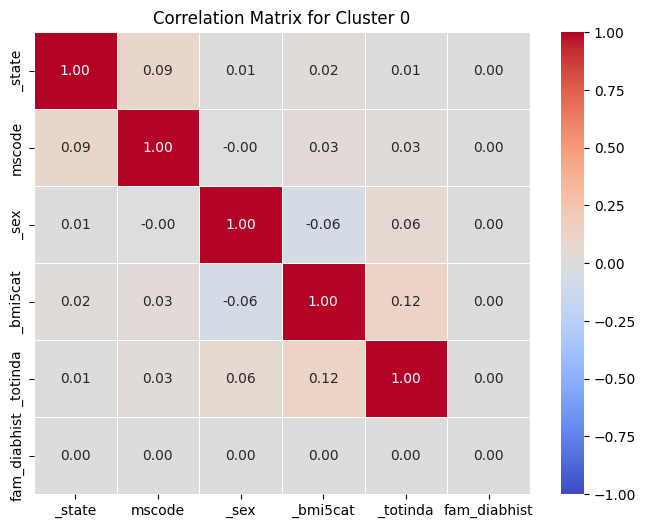

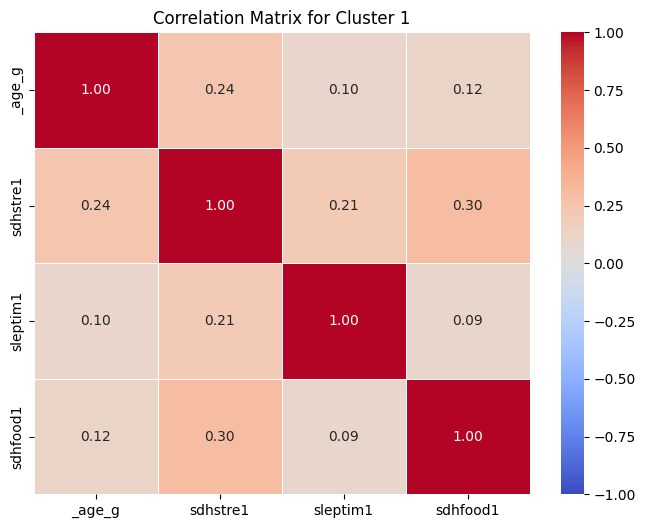

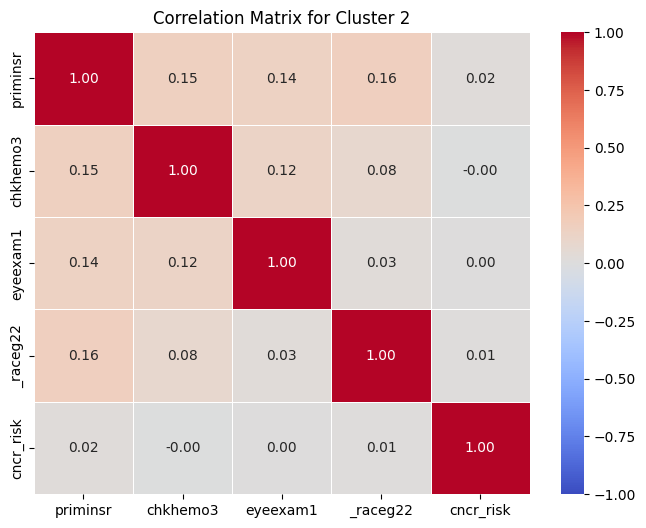

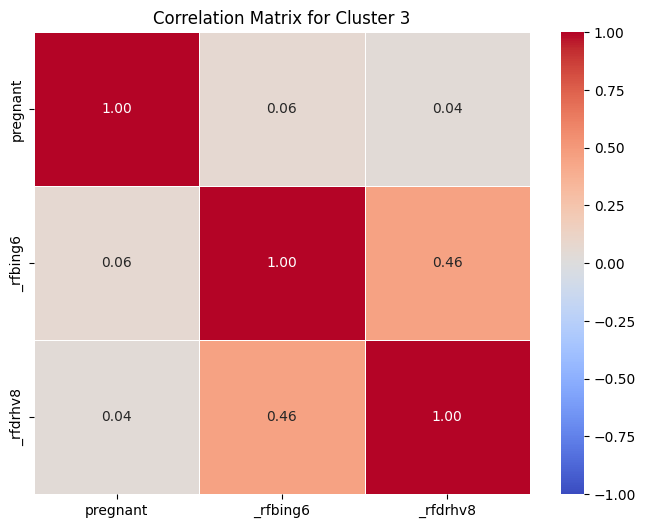

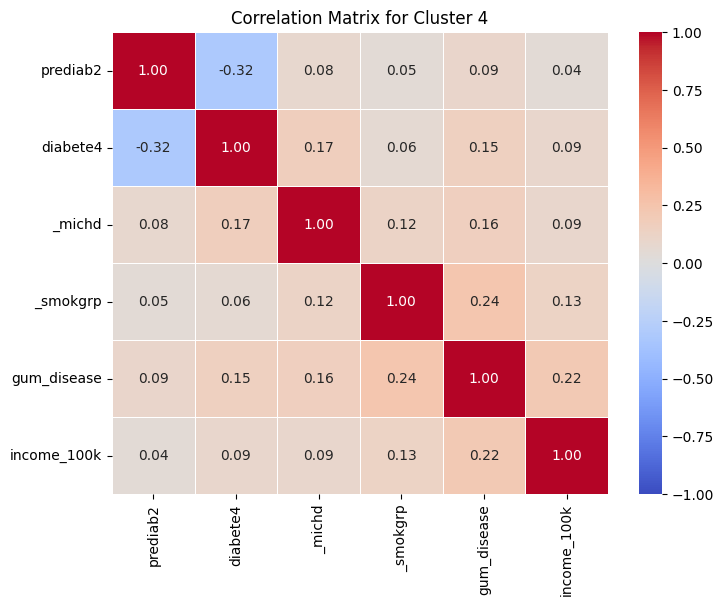

In [113]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Check for NaNs in the correlation matrix
if correlation_matrix.isnull().values.any():
    print("NaNs detected in the correlation matrix.")
    # Impute NaNs with 0 in the correlation matrix
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    correlation_matrix = pd.DataFrame(imputer.fit_transform(correlation_matrix), index=correlation_matrix.index, columns=correlation_matrix.columns)

# Flatten correlation matrix and standardize for clustering
corr_matrix_flat = correlation_matrix.values
scaler = StandardScaler()
scaled_corr_matrix = scaler.fit_transform(corr_matrix_flat)

# Perform K-Means clustering
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(scaled_corr_matrix)

# Create a DataFrame with cluster labels for each feature
feature_clusters = pd.DataFrame({
    'Feature': correlation_matrix.columns,
    'Cluster': clusters
})

# Plot correlation matrices for each cluster
for cluster in range(num_clusters):
    # Get features in the current cluster
    cluster_features = feature_clusters[feature_clusters['Cluster'] == cluster]['Feature']
    cluster_corr_matrix = correlation_matrix.loc[cluster_features, cluster_features]

    plt.figure(figsize=(8, 6))  # Set the size of the plot
    sns.heatmap(cluster_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix for Cluster {cluster}')
    plt.show()

In [114]:
# Sort feature_clusters by 'Feature'
sorted_feature_clusters = feature_clusters.sort_values(by=['Feature'])

# Create clusters_summary from the sorted DataFrame
clusters_summary = sorted_feature_clusters.groupby('Cluster')['Feature'].apply(list)

# Loop through each unique cluster and print sorted features
for cluster, features in clusters_summary.items():
    print(f"Cluster {cluster}:")
    for feature in features:
        print(f"  {feature}")
    print()  # Blank line for better readability

Cluster 0:
  _bmi5cat
  _sex
  _state
  _totinda
  fam_diabhist
  mscode

Cluster 1:
  _age_g
  sdhfood1
  sdhstre1
  sleptim1

Cluster 2:
  _raceg22
  chkhemo3
  cncr_risk
  eyeexam1
  priminsr

Cluster 3:
  _rfbing6
  _rfdrhv8
  pregnant

Cluster 4:
  _michd
  _smokgrp
  diabete4
  gum_disease
  income_100k
  prediab2



#### Highly correlated with diabete4

In [116]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Extract correlations with 'diabete4'
diabete4_corr = correlation_matrix['diabete4'].sort_values(ascending=False)

# Print correlations with 'diabete4'
print("Correlations with 'diabete4':")
print(diabete4_corr.head(30))
print(diabete4_corr.tail(30))

# Filter out the target variable itself (if you don't want to include it)
high_corr_features = diabete4_corr[diabete4_corr.index != 'diabete4']

# Display highly correlated features (e.g., correlation > 0.5 or < -0.5)
high_corr_features = high_corr_features[(high_corr_features > 0.5) | (high_corr_features < -0.5)]
print("\nHighly correlated features with 'diabete4':")
print(high_corr_features)

Correlations with 'diabete4':
diabete4        1.000000
_michd          0.165560
gum_disease     0.151855
income_100k     0.089554
_rfbing6        0.084878
sdhfood1        0.062386
_smokgrp        0.057252
_rfdrhv8        0.057252
priminsr        0.032157
cncr_risk       0.011977
_sex            0.009105
mscode          0.007762
_state         -0.004772
sdhstre1       -0.006288
pregnant       -0.007430
sleptim1       -0.008197
_raceg22       -0.030703
_totinda       -0.131342
_bmi5cat       -0.163837
_age_g         -0.193188
prediab2       -0.320197
chkhemo3             NaN
eyeexam1             NaN
fam_diabhist         NaN
Name: diabete4, dtype: float64
diabete4        1.000000
_michd          0.165560
gum_disease     0.151855
income_100k     0.089554
_rfbing6        0.084878
sdhfood1        0.062386
_smokgrp        0.057252
_rfdrhv8        0.057252
priminsr        0.032157
cncr_risk       0.011977
_sex            0.009105
mscode          0.007762
_state         -0.004772
sdhstre1      

In [117]:
# Filter out the target variable itself (if you don't want to include it)
high_corr_features = diabete4_corr[diabete4_corr.index != 'diabete4']

# Display highly correlated features (e.g., correlation > 0.5 or < -0.5)
high_corr_features = high_corr_features[(high_corr_features > 0.1) | (high_corr_features < -0.1)]
print("\nHighly correlated features with 'diabete4':")
print(high_corr_features)


Highly correlated features with 'diabete4':
_michd         0.165560
gum_disease    0.151855
_totinda      -0.131342
_bmi5cat      -0.163837
_age_g        -0.193188
prediab2      -0.320197
Name: diabete4, dtype: float64


#### No Correlation with diabete4

Let's print the features that have the least correlation in either the positive or negative direction with our target. We might consider dropping these, depending on how well (or not well) our model runs.

However, low correlation doesn't necessarily mean anything. **If the relationships are non-linear, the numbers below will not help us**.

In [118]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Extract correlations with 'diabete4'
diabete4_corr = correlation_matrix['diabete4']

# Filter features with correlation less than 0.1 but greater than -0.1
filtered_corr = diabete4_corr[(diabete4_corr < 0.1) & (diabete4_corr > -0.1)]

# Sort the filtered correlations in ascending order
sorted_corr = filtered_corr.sort_values(ascending=True)

# Print feature names and their correlation values
print("Features with correlation to 'diabete4' between -0.1 and 0.1 (sorted in ascending order):")
for feature, corr_value in sorted_corr.items():
    print(f"{feature}: {corr_value:.4f}")

Features with correlation to 'diabete4' between -0.1 and 0.1 (sorted in ascending order):
_raceg22: -0.0307
sleptim1: -0.0082
pregnant: -0.0074
sdhstre1: -0.0063
_state: -0.0048
mscode: 0.0078
_sex: 0.0091
cncr_risk: 0.0120
priminsr: 0.0322
_rfdrhv8: 0.0573
_smokgrp: 0.0573
sdhfood1: 0.0624
_rfbing6: 0.0849
income_100k: 0.0896


# Modeling - Prepping Target

There are so few NaNs in our target variable, diabete4, let's just drop those rows altogether.

In [119]:
# Drop rows where 'diabete4' is NaN
df = df.dropna(subset=['diabete4'])

In [120]:
# Impute all NaN values with 0
df = df.fillna(0)

## Binary Classification

Let's double check our value counts to make sure we're running a baseline model that only determines whether someone does or does not have diabetes.

In [121]:
df['diabete4'].value_counts()

,count
diabete4,
3.0,368722
1.0,61158
4.0,10329
2.0,3836


4 possible values in our target class. Let's use our codebook key dictionary to remind ourselves what they are, then keep only the concrete 'Yes' or 'No'.

In [122]:
codebook_key

{'diabete4': {'Question': "(Ever told) (you had) diabetes? (If 'Yes' and respondent is female, ask 'Was this only when you were pregnant?´.",
  'Answers': {1: 'Yes',
   2: 'Yes, but female told only during pregnancy',
   3: 'No',
   4: 'No, pre-diabetes or boderline diabetes',
   7: 'Dont know/Not sure',
   9: 'Refused',
   'BLANK': 'Not asked or Missing'}},
 '_smokgrp': {'Question': 'Smoking Group',
  'Answers': {1: 'Current smoker, 20+ Pack Years',
   2: 'Former smoker, 20+ Pack years, quit < 15 years',
   3: 'All other current and former smokers',
   4: 'Never smoker',
   0: 'Dont know/Refused/Missing'}},
 '_age_g': {'Question': 'Six-level imputed age category',
  'Answers': {1: 'Age 18 to 24',
   2: 'Age 25 to 34',
   3: 'Age 35 to 44',
   4: 'Age 45 to 54',
   5: 'Age 55 to 64',
   6: 'Age 65 or older'}},
 'cncrage': {'Question': 'At what age were you told that you had cancer? (If Response = 2 (Two) or 3 (Three or more), ask: “At what age was your first diagnosis of cancer?”)',
  

##### 2: Only during pregnancy

Let's drop 'Yes, but female told only during pregnancy' for now, since we can assume the direct cause and we need to make our models even simpler to be able to run for our FSM. We can always add this in later if we want to make the model more complex.

In [143]:
# Filetering for only yes or no
filtered = df[df['diabete4'].isin([1.0, 3.0])]

# Multinomial Naive Bayes Classifier

Logistic Regression is having problems running. Multinomial Naive Bayes usually runs faster on larger datasets. Let's try that one first.

### Train Test Split

In [145]:
X = filtered.drop(columns=['diabete4'])
y = filtered['diabete4']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Class Imbalance: SMOTE

Our class imbalance is severe enough, and this is a binary classification problem, so we'll use SMOTE to handle class imbalance.

In [146]:
y_train.value_counts(normalize=True)

,proportion
diabete4,
0.0,0.85796
1.0,0.14204


In [147]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from joblib import parallel_backend
from sklearn.metrics import classification_report

# Assuming 'filtered' DataFrame is already defined
X = filtered.drop(columns=['diabete4'])
y = filtered['diabete4']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the pipeline with SMOTE and MultinomialNB
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('mnb', MultinomialNB())
])

# Define the parameter grid
param_grid = {
    'mnb__alpha': [0.01, 0.1, 1, 10],
    'mnb__fit_prior': [True, False]
}

# Initialize GridSearchCV with recall as the scoring metric
with parallel_backend('loky'):
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='recall_weighted',  # Use recall as the primary metric
        n_jobs=-1,  # Use all available cores
        verbose=1  # Print progress
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Print best parameters and best score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best recall score: {grid_search.best_score_:.4f}")

    # Evaluate on test data
    y_pred = grid_search.best_estimator_.predict(X_test)
    print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'mnb__alpha': 0.01, 'mnb__fit_prior': True}
Best recall score: 0.6724
              precision    recall  f1-score   support

         0.0       0.95      0.65      0.77    110548
         1.0       0.28      0.79      0.41     18416

    accuracy                           0.67    128964
   macro avg       0.61      0.72      0.59    128964
weighted avg       0.85      0.67      0.72    128964



In [148]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Define your target variable
target = 'diabete4'

# Separate features and target variable
X = filtered.drop(columns=[target])
y = filtered[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check class distribution
print("Class distribution in training set:")
print(y_train.value_counts())

# Adjust SMOTE parameters if needed
smote = SMOTE(sampling_strategy='auto', k_neighbors=min(5, y_train.value_counts().min() - 1), random_state=42)

# Create a pipeline with SMOTE and StandardScaler
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('smote', smote),  # Handling class imbalance
    ('model', LogisticRegression(max_iter=1000, random_state=42))  # Logistic Regression model
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model using recall
recall = recall_score(y_test, y_pred, average='weighted')  # 'weighted' for multiclass classification
print(f'Recall Score: {recall:.4f}')

# Print detailed classification report
print(classification_report(y_test, y_pred))


Class distribution in training set:
diabete4
0.0    258174
1.0     42742
Name: count, dtype: int64
Recall Score: 0.7559
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84    110548
         1.0       0.35      0.84      0.49     18416

    accuracy                           0.76    128964
   macro avg       0.66      0.79      0.67    128964
weighted avg       0.88      0.76      0.79    128964



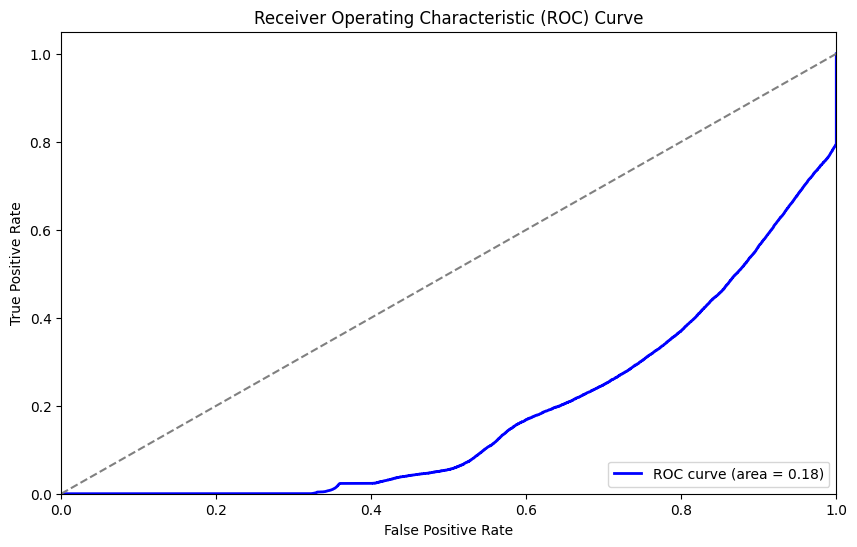

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall Score: 0.1132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    110548
         1.0       0.28      0.79      0.41     18416
         3.0       0.00      0.00      0.00         0

    accuracy                           0.11    128964
   macro avg       0.09      0.26      0.14    128964
weighted avg       0.04      0.11      0.06    128964



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [131]:
# Assuming '1.0' is the positive class and '3.0' is the negative class
positive_class = 1.0
negative_class = 3.0

# Convert the labels to binary format
y_test_binary = np.where(y_test == positive_class, 1, 0)
y_prob_binary = np.where(grid_search.predict_proba(X_test)[:, 1] > 0.5, 1, 0)  # use a threshold for binary prediction

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, grid_search.predict_proba(X_test)[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model using recall
recall = recall_score(y_test_binary, grid_search.predict(X_test), average='weighted')  # 'weighted' for multiclass classification
print(f'Recall Score: {recall:.4f}')

# Print detailed classification report
print(classification_report(y_test_binary, grid_search.predict(X_test)))

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Define your target variable
target = 'diabete4'  # Replace with your actual target variable name

# Separate features and target variable
X = filtered.drop(columns=[target])
y = filtered[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the SMOTE parameters
smote = SMOTE(random_state=42)

# Define the logistic regression model
log_reg = LogisticRegression(max_iter=5000, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'model__C': [0.01, 0.1, 1],
    'model__penalty': ['l2', 'none'],
    'model__class_weight': [None, 'balanced']
}

# Create a pipeline with SMOTE, StandardScaler, and Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('smote', smote),  # Handling class imbalance
    ('model', log_reg)  # Logistic Regression model
])

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring='recall_weighted', cv=3, n_jobs=-1)

# Train the model
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Best parameters found:  {'model__C': 0.01, 'model__class_weight': None, 'model__penalty': 'none'}
Best score:  0.7552871922599266


In [150]:
# Make predictions using the best model
y_pred = grid_search.predict(X_test)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84    110548
         1.0       0.35      0.84      0.49     18416

    accuracy                           0.76    128964
   macro avg       0.66      0.79      0.67    128964
weighted avg       0.88      0.76      0.79    128964



In [ ]:
# Make predictions and compute probability estimates
y_prob = grid_search.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Ensure binary classification labels
# Convert non-binary labels to binary if necessary
positive_class = 1.0
negative_class = 3.0
y_test_binary = np.where(y_test == positive_class, 1, 0)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model using recall
y_pred = grid_search.predict(X_test)
recall = recall_score(y_test_binary, y_pred, average='weighted')  # 'weighted' for multiclass classification
print(f'Recall Score: {recall:.4f}')

# Print detailed classification report
print(classification_report(y_test_binary, y_pred))

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Define your target variable
target = 'diabete4'  # Replace with your actual target variable name

# Separate features and target variable
X = filtered.drop(columns=[target])
y = filtered[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100],  # Number of trees in the forest
    'max_depth': [10, 20],  # Maximum depth of the tree
    'min_samples_split': [5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 4],    # Minimum number of samples required to be at a leaf node
}

# Set up GridSearchCV
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, scoring='recall_weighted', cv=5, n_jobs=-1)

# Train the model
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search_rf.best_params_)
print("Best score: ", grid_search_rf.best_score_)

NameError: name 'filtered' is not defined

In [152]:
# Get the best model from grid search
best_rf_model = grid_search_rf.best_estimator_

# Make predictions using the best model
y_pred = best_rf_model.predict(X_test)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89    110548
         1.0       0.43      0.78      0.55     18416

    accuracy                           0.82    128964
   macro avg       0.69      0.80      0.72    128964
weighted avg       0.88      0.82      0.84    128964



In [153]:
# Print feature importances
feature_importances = best_rf_model.feature_importances_
features = X.columns

# Create a DataFrame to hold feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
         Feature  Importance
3       prediab2    0.294541
10        _age_g    0.124557
5       eyeexam1    0.085220
11      _bmi5cat    0.070817
2         _state    0.063762
4       chkhemo3    0.058024
20   gum_disease    0.038370
0       priminsr    0.037321
7         _michd    0.033157
17      sleptim1    0.029992
15      _totinda    0.023808
8       _raceg22    0.018265
22   income_100k    0.017253
16      sdhstre1    0.016449
12      _smokgrp    0.015728
1       pregnant    0.015705
18      sdhfood1    0.012527
6         mscode    0.012406
13      _rfbing6    0.012231
14      _rfdrhv8    0.010031
9           _sex    0.008594
19     cncr_risk    0.001114
21  fam_diabhist    0.000127


In [ ]:
# Make predictions and compute probability estimates
y_prob = grid_search_rf.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Ensure binary classification labels
positive_class = 1.0
negative_class = 3.0
y_test_binary = np.where(y_test == positive_class, 1, 0)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model using precision-recall curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_prob)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Evaluate the model using classification report
y_pred = grid_search_rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test_binary, y_pred))

In [155]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.3 MB/s eta 0:00:00


In [3]:
import shap
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test)

NameError: name 'y_test' is not defined

In [2]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values (bar plot)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary plot of SHAP values
shap.summary_plot(shap_values, X_test)

NameError: name 'shap' is not defined